#Predicting the winner and point spread of NBA games using box score and advanced metrics

####Luis Morales, Isaak Haberman and Priyadrshini Sawant

## Introduction


According to the Pew Research Center, nearly 1 out of every 5 adults has bet on a sports game in the past year. Sports betting is a lucrative, enigmatic, and controversial industry that millions of people participate in. Therefore, the ability to predict the outcome of major sporting events is a potentially valuable opportunity. We set out to predict the winner and point spread of NBA games using metrics provided by the NBA for each game from the 2018-2019, 2019-2020, 2020-2021, and 2021-2022 seasons. There are 30 NBA teams who play 82 games each season. This provides the opportunity of a large dataset. Moreover, basketball is a sport that has seen a recent increase in more advanced latent variables that are calculated from simpler metrics and who supposedly have a high predictive power in the success rates of different teams. In this study, we took the running average of each teams' metrics over their past 30 games to predict whether they would win or lose a certain game and how large the difference in score would be. 

Data was obtained from the NBA Website at: https://www.nba.com/stats/teams/boxscores and https://www.nba.com/stats/teams/boxscores-advanced.

## Import and install libraries

This first installation is necessary for our later cluster analysis. It allows us to adjust text labels so they don't overlap

In [1]:
pip install https://github.com/Phlya/adjustText/archive/master.zip;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/Phlya/adjustText/archive/master.zip


In [2]:
import graphviz 
import adjustText
import numpy as np
import pandas as pd
import seaborn as sns    
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, ParameterGrid

In [3]:
sns.set()
sns.set_context('talk')  
sns.set_style('whitegrid') # larger

# set default plot size
rcParams['figure.figsize'] = 8,6

## Functions

Below are three functions taken from lectures and homework exercises that will aid us in visualizing and analyzing our machine learning processes. These functions will allow us to plot decision trees and learning curves, and print confusion matrices. We have altered these functions slightly to serve the purposes necessary for this report.

In [4]:
def plot_tree_custom(cv):
    target_names = ['Home Loss', 'Home Win']
    dot_data = export_graphviz(cv.best_estimator_, precision=2,
                         feature_names=predictors,  
                         proportion=True,
                         class_names=target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

    # plot it
    graph = graphviz.Source(dot_data)  
    return graph

In [5]:
def plot_learning_curve(clf, X_train, y_train):
    # generate the data; average the values
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve')
    plt.legend();

In [6]:
def print_conf_mtx(y_true, y_pred, classes=None, norm=None):
    """ Print a confusion matrix (two classes only). """
    
    if not classes:
        classes = ['neg', 'pos']
        
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left       = '{:<10s}'.replace('10',str(n))
    right      = '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    if (norm == None):
      cm = confusion_matrix(y_true, y_pred, normalize=norm)
    else:
      cm = confusion_matrix(y_true, y_pred, normalize=norm).round(3)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

## Read the data

Data was uploaded from Luis Morales' GitHub page. 

In [7]:
df_box_2018 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2018%20-%20box.csv")
df_adv_2018 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2018%20-%20advanced.csv")
df_box_2019 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2019%20-%20box.csv")
df_adv_2019 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2019%20-%20advanced.csv")
df_box_2020 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2020%20-%20box.csv")
df_adv_2020 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2020%20-%20advanced.csv")
df_box_2021 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2021%20-%20box.csv")
df_adv_2021 = pd.read_csv("https://raw.githubusercontent.com/LuiM112/NBAData/main/NBA_2021%20-%20advanced.csv")

## Initial Data Exploration

The data available publically regarding NBA games lists each team's stats for each game, per year. The dataframes for regular and advanced metrics are available separately.

In [8]:
df_box_2020.head(5)

,TEAM,MATCH UP,GAME DATE,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS/MINUS
0,MEM,MEM @ GSW,5/16/2021,L,240,101,40,92,43.5,6,...,78.9,12,27,39,25,12,5,13,21,-12
1,DET,DET vs. MIA,05/16/2021,L,240,107,40,86,46.5,11,...,72.7,7,26,33,26,4,4,16,21,-13
2,MIL,MIL @ CHI,05/16/2021,L,240,112,38,90,42.2,12,...,75.0,10,31,41,14,13,5,12,16,-6
3,WAS,WAS vs. CHA,05/16/2021,W,240,115,44,91,48.4,10,...,81.0,10,43,53,22,4,3,14,20,5
4,NOP,NOP vs. LAL,05/16/2021,L,240,98,37,78,47.4,9,...,71.4,8,39,47,26,4,5,21,18,-12


In [9]:
df_adv_2020.head(5)

,TEAM,MATCH UP,GAME DATE,W/L,MIN,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,ASTRATIO,OREB%,DREB%,REB%,TOV%,EFG%,TS%,PACE,PIE
0,SAS,SAS vs. PHX,5/16/21,L,48,117.5,118.3,-0.8,60.0,3.00,20.7,25.5,74.5,50.0,9.7,54.6,56.9,103.5,47.9
1,SAC,SAC vs. UTA,5/16/21,L,48,97.1,119.8,-22.7,57.1,1.85,18.0,14.3,74.5,43.8,12.7,51.7,52.4,101.5,40.3
2,CHA,CHA @ WAS,05/16/2021,L,48,105.8,112.7,-7.0,67.6,1.92,17.4,25.4,72.9,46.7,12.5,46.8,52.6,103.0,47.5
3,CHI,CHI vs. MIL,05/16/2021,W,48,113.5,107.7,5.8,51.1,1.44,16.8,25.0,74.1,52.0,15.4,59.8,61.9,104.0,55.4
4,IND,IND @ TOR,05/16/2021,W,48,117.9,107.6,10.3,70.8,2.62,22.4,27.1,67.8,49.5,12.3,58.4,60.7,105.5,57.2


Here we can see for that both box score and advanced metrics, each game will have 2 rows, one for each team. We also check the columns, entries, and data types for each type of dataframe.

In [10]:
df_box_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TEAM        2160 non-null   object 
 1   MATCH UP    2160 non-null   object 
 2   GAME DATE   2160 non-null   object 
 3   W/L         2160 non-null   object 
 4   MIN         2160 non-null   int64  
 5   PTS         2160 non-null   int64  
 6   FGM         2160 non-null   int64  
 7   FGA         2160 non-null   int64  
 8   FG%         2160 non-null   float64
 9   3PM         2160 non-null   int64  
 10  3PA         2160 non-null   int64  
 11  3P%         2160 non-null   float64
 12  FTM         2160 non-null   int64  
 13  FTA         2160 non-null   int64  
 14  FT%         2160 non-null   float64
 15  OREB        2160 non-null   int64  
 16  DREB        2160 non-null   int64  
 17  REB         2160 non-null   int64  
 18  AST         2160 non-null   int64  
 19  STL         2160 non-null  

In [11]:
df_adv_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TEAM       2160 non-null   object 
 1   MATCH UP   2160 non-null   object 
 2   GAME DATE  2160 non-null   object 
 3   W/L        2160 non-null   object 
 4   MIN        2160 non-null   int64  
 5   OFFRTG     2160 non-null   float64
 6   DEFRTG     2160 non-null   float64
 7   NETRTG     2160 non-null   float64
 8   AST%       2160 non-null   float64
 9   AST/TO     2160 non-null   float64
 10  ASTRATIO   2160 non-null   float64
 11  OREB%      2160 non-null   float64
 12  DREB%      2160 non-null   float64
 13  REB%       2160 non-null   float64
 14  TOV%       2160 non-null   float64
 15  EFG%       2160 non-null   float64
 16  TS%        2160 non-null   float64
 17  PACE       2160 non-null   float64
 18  PIE        2160 non-null   float64
dtypes: float64(14), int64(1), object(4)
memory usage

We also see that the box score data has 24 features and the advanced data has 19 features. Of these features, 20 of the box score stats and 14 of the advanced metrics could are considered team-based statistics and can be predictors or target variables for our assessment. Team, Match Up, and Game Date do not have predictive power but will be useful in preparing the data for machine learning. The Min column in both datasets is uniformative as NBA games are all a certain length (48 minutes plus potentially 5 minutes for overtime).

It looks like our datasets do not have any NA values, since all entry numbers are the same for each column. However, it is possible that there are NA values for every column in some rows. To check this, we calculate the number of NA values in each dataframe.

In [12]:
print("2018 box score NA values:", df_box_2018.isna().sum().sum())
print("2018 advanced score NA values:", df_adv_2018.isna().sum().sum())
print("2019 box score NA values:", df_box_2019.isna().sum().sum())
print("2019 advanced score NA values:", df_adv_2019.isna().sum().sum())
print("2020 box score NA values:", df_box_2020.isna().sum().sum())
print("2020 advanced metric NA values:", df_adv_2020.isna().sum().sum())
print("2021 box score NA values:", df_box_2021.isna().sum().sum())
print("2021 advanced metric NA values:", df_adv_2021.isna().sum().sum())

2018 box score NA values: 0
2018 advanced score NA values: 0
2019 box score NA values: 0
2019 advanced score NA values: 0
2020 box score NA values: 0
2020 advanced metric NA values: 0
2021 box score NA values: 0
2021 advanced metric NA values: 0


There are no NA values in our dataset, so we can proceed with preprocessing.

## Data Preprocessing

The first step in preparing the data is to join the advanced and box score datasets into 1 dataframe for each year. We do this with a join function based on match up and game date, since each set of teams will only play once on any given day. After joining the dataframes, we will reverse their orders since we want them in chronological order, not reverse chronological order as the data was loaded.

In [13]:
df_2018 = df_box_2018.merge(df_adv_2018, how='inner', on=['MATCH UP', 'GAME DATE'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df_2019 = df_box_2019.merge(df_adv_2019, how='inner', on=['MATCH UP', 'GAME DATE'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df_2020 = df_box_2020.merge(df_adv_2020, how='inner', on=['MATCH UP', 'GAME DATE'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df_2021 = df_box_2021.merge(df_adv_2021, how='inner', on=['MATCH UP', 'GAME DATE'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

df_2018 = df_2018.iloc[::-1]
df_2019 = df_2019.iloc[::-1]
df_2020 = df_2020.iloc[::-1]
df_2021 = df_2021.iloc[::-1]

We cannot yet merge the 2020 and 2021 dataframes since the running averages that need to be calculated cannot run between the two years. We made this decision since it is unlikely that stats from the end of the 2020 season will affect how well a team starts the 2021 season.

Next, we add and edit some of the columns to make them more useful for processing. We first add a column 'HOME' that is set to 1 if the team is a home team for that game and 0 if the stats represent an away game. If the 'MATCH UP' column contains the '@' symbol, the game represented an away game for that team. Otherwise, it was a home game. We also add an 'OPPONENT' column to represent the team that the team whose stats are represented it playing. We take this from the last 3 characters of the 'MATCH UP' column which is always TEAM1 @/vs. TEAM2 where each team is represented by a 3 letter abbreviation. We also converted the 'GAME DATE' column to a pandas datetime. We edited the 'MATCH UP' column to be the same for each separate game. Before, the 'MATCH UP' column was represented by 'TEAM1 @ TEAM2' for the away team and 'TEAM2 vs. TEAM1' for the home team. Here, we edit the column to remove the '@' or 'vs.' part and to make the teams appear in the same order. This way, we can use the 'MATCH UP' column to pair the two rows from the same game. Finally, we dropped the 'MIN' column since it is the same for almost every game (save games that went into overtime).


In [14]:
df_2018['HOME'] = np.where(df_2018['MATCH UP'].str.contains("@"), 0, 1)
df_2018['OPPONENT'] = df_2018['MATCH UP'].str[-3:]
df_2018['GAME DATE'] = pd.to_datetime(df_2018['GAME DATE'])
df_2018['MATCH UP'] = np.where(df_2018['HOME'] == 1, df_2018['MATCH UP'].str[:3] + df_2018['MATCH UP'].str[-3:], df_2018['MATCH UP'].str[-3:] + df_2018['MATCH UP'].str[:3])
df_2018.drop(columns = ['MIN'], inplace=True)

df_2019['HOME'] = np.where(df_2019['MATCH UP'].str.contains("@"), 0, 1)
df_2019['OPPONENT'] = df_2019['MATCH UP'].str[-3:]
df_2019['GAME DATE'] = pd.to_datetime(df_2019['GAME DATE'])
df_2019['MATCH UP'] = np.where(df_2019['HOME'] == 1, df_2019['MATCH UP'].str[:3] + df_2019['MATCH UP'].str[-3:], df_2019['MATCH UP'].str[-3:] + df_2019['MATCH UP'].str[:3])
df_2019.drop(columns = ['MIN'], inplace=True)

df_2020['HOME'] = np.where(df_2020['MATCH UP'].str.contains("@"), 0, 1)
df_2020['OPPONENT'] = df_2020['MATCH UP'].str[-3:]
df_2020['GAME DATE'] = pd.to_datetime(df_2020['GAME DATE'])
df_2020['MATCH UP'] = np.where(df_2020['HOME'] == 1, df_2020['MATCH UP'].str[:3] + df_2020['MATCH UP'].str[-3:], df_2020['MATCH UP'].str[-3:] + df_2020['MATCH UP'].str[:3])
df_2020.drop(columns = ['MIN'], inplace=True)

df_2021['HOME'] = np.where(df_2021['MATCH UP'].str.contains("@"), 0, 1)
df_2021['OPPONENT'] = df_2021['MATCH UP'].str[-3:]
df_2021['GAME DATE'] = pd.to_datetime(df_2021['GAME DATE'])
df_2021['MATCH UP'] = np.where(df_2021['HOME'] == 1, df_2021['MATCH UP'].str[:3] + df_2021['MATCH UP'].str[-3:], df_2021['MATCH UP'].str[-3:] + df_2021['MATCH UP'].str[:3])
df_2021.drop(columns = ['MIN'], inplace=True)

Next, we will make the average stats dataframes by adding all the columns that we need from the box scores and advanced stats.

In [15]:
df_avg_2018 = pd.DataFrame(columns = ['TEAM', 'OPPONENT', 'MATCH UP', 'HOME', 'GAME DATE', 
                                 'W/L', 'PLUS/MINUS','PTS', 'FGM', 'FGA', 'FG%', '3PM', 
                                 '3PA','3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
                                 'AST', 'STL', 'BLK','TOV', 'PF',  'OFFRTG', 'DEFRTG',
                                 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 'OREB%', 'DREB%', 
                                 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE'], index = range(len(df_2018)))

df_avg_2019 = pd.DataFrame(columns = ['TEAM', 'OPPONENT', 'MATCH UP', 'HOME', 'GAME DATE', 
                                 'W/L', 'PLUS/MINUS','PTS', 'FGM', 'FGA', 'FG%', '3PM', 
                                 '3PA','3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
                                 'AST', 'STL', 'BLK','TOV', 'PF',  'OFFRTG', 'DEFRTG',
                                 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 'OREB%', 'DREB%', 
                                 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE'], index = range(len(df_2019)))

df_avg_2020 = pd.DataFrame(columns = ['TEAM', 'OPPONENT', 'MATCH UP', 'HOME', 'GAME DATE', 
                                 'W/L', 'PLUS/MINUS','PTS', 'FGM', 'FGA', 'FG%', '3PM', 
                                 '3PA','3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
                                 'AST', 'STL', 'BLK','TOV', 'PF',  'OFFRTG', 'DEFRTG',
                                 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 'OREB%', 'DREB%', 
                                 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE'], index = range(len(df_2020)))

df_avg_2021 = pd.DataFrame(columns = ['TEAM', 'OPPONENT', 'MATCH UP', 'HOME', 'GAME DATE', 
                                 'W/L', 'PLUS/MINUS','PTS', 'FGM', 'FGA', 'FG%', '3PM', 
                                 '3PA','3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
                                 'AST', 'STL', 'BLK','TOV', 'PF',  'OFFRTG', 'DEFRTG',
                                 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 'OREB%', 'DREB%', 
                                 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE'], index = range(len(df_2021)))

Now, we will calculate the running averages for each team for the prior n games. This will be done using a function that loops through and subsets the data for each team, adds the correct values for the team, opponent, match up, game date, home, W/L, and plus/minus columns, then averages the stats columns over the last n games. The function will then drop all the  the rows with NA values. These rows represent the first 30 games for each team, as we cannot calculate running averages for the last 30 games before each team has played 30 games. We also recast the statistic variables as floats, and the 'PLUS/MINUS' and 'HOME' columns as integers. 

In [16]:
def running_averages(df, df_avg, window):
  cur = 0
  window = window
  for team in df['TEAM'].unique():
    df_t = df[df['TEAM'] == team]
    for i in range(len(df_t)):
        df_avg.loc[:, 'TEAM'].iloc[i+cur] = team
        df_avg.loc[:, 'OPPONENT'].iloc[i+cur] = df_t.loc[:, 'OPPONENT'].iloc[i]
        df_avg.loc[:, 'MATCH UP'].iloc[i+cur] = df_t.loc[:, 'MATCH UP'].iloc[i]
        df_avg.loc[:, 'GAME DATE'].iloc[i+cur] = df_t.loc[:, 'GAME DATE'].iloc[i]
        df_avg.loc[:, 'HOME'].iloc[i+cur] = df_t.loc[:, 'HOME'].iloc[i]
        df_avg.loc[:, 'W/L'].iloc[i+cur] = df_t.loc[:, 'W/L'].iloc[i]
        df_avg.loc[:, 'PLUS/MINUS'].iloc[i+cur] = df_t.loc[:, 'PLUS/MINUS'].iloc[i]
        for col in ['PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
           '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
           'TOV', 'PF', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 
           'OREB%', 'DREB%', 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE']:
                df_avg.loc[:,col].iloc[i+cur] = np.mean(df_t[col][i-window:i])
    cur = cur + len(df_t)
  df_avg.dropna(inplace=True)
  for col in ['PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
   '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
   'TOV', 'PF', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 
   'OREB%', 'DREB%', 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE']:
    df_avg[col] = df_avg[col].astype(float)
  df_avg['PLUS/MINUS'] = df_avg['PLUS/MINUS'].astype(int)
  df_avg['HOME'] = df_avg['HOME'].astype(int)
  return df_avg

Now, we can use this function for both each years' dataframe (note this code will take about 2 minutes to run).

In [17]:
df_avg_2018 = running_averages(df_2018, df_avg_2018, 30)
df_avg_2019 = running_averages(df_2019, df_avg_2019, 30)
df_avg_2020 = running_averages(df_2020, df_avg_2020, 30)
df_avg_2021 = running_averages(df_2021, df_avg_2021, 30)

Next, we can sort the dataframes by 'GAME DATE' and 'MATCH UP' to line up rows of the same game. This will be useful when we merge the two rows from the same game into 1 row

In [18]:
df_avg_2018 = df_avg_2018.sort_values(by=['GAME DATE', 'MATCH UP']).reset_index(drop=True)
df_avg_2019 = df_avg_2019.sort_values(by=['GAME DATE', 'MATCH UP']).reset_index(drop=True)
df_avg_2020 = df_avg_2020.sort_values(by=['GAME DATE', 'MATCH UP']).reset_index(drop=True)
df_avg_2021 = df_avg_2021.sort_values(by=['GAME DATE', 'MATCH UP']).reset_index(drop=True)


After sorting the averaged dataframes, we are almost ready to merge each row of the same game into one row. However, first we need to account for the fact that near the beginning of each dataframe, there were some games where one team will have played 30 games and the other won't. This resulted in only one row being dropped for certain games where one of the teams hadn't played 30 games yet but the other had. To remedy this issue, we will drop all rows that do not have another row from the same game to be paired to.

The function here will fill a list of indices to be dropped and then drop those rows from the dataframe. It will compare the current row's 'MATCH UP' to the 'MATCH UP' above and below it (or in the case of the first and last rows, only one comparison). Since the dataframe has been sorted by 'GAME DATE' and 'MATCH UP', if there is not a row that has the same 'MATCH UP' directly below or above the current row, it is part of a game where the other team had not yet played 30 games and needs to be dropped.

In [19]:
def drop_singles(df):
  drop_list = []
  for i in range(len(df)):
    if i == 0:
      if (df.loc[:,'MATCH UP'].iloc[i] != df.loc[:,'MATCH UP'].iloc[i+1]):
        drop_list.append(i)
    elif i == (len(df) - 1):
      if (df.loc[:,'MATCH UP'].iloc[i] != df.loc[:,'MATCH UP'].iloc[i-1]):
        drop_list.append(i)
    else:
      if (df.loc[:,'MATCH UP'].iloc[i] != df.loc[:,'MATCH UP'].iloc[i+1]) & (df.loc[:,'MATCH UP'].iloc[i] != df.loc[:,'MATCH UP'].iloc[i-1]):
        drop_list.append(i)
  df.drop(drop_list, inplace=True)
  return df

Now, we will use this function on the 2020 and 2021 dataframes

In [20]:
df_avg_2018 = drop_singles(df_avg_2018)
df_avg_2019 = drop_singles(df_avg_2019)
df_avg_2020 = drop_singles(df_avg_2020)
df_avg_2021 = drop_singles(df_avg_2021)

In order to merge rows of similar games, we first separate each year's dataframe into a dataframe of only the home teams and a dataframe of only the away teams. Then, we create the columns for a final dataframe and use a concatenate function to pair each games rows into a single row. Each statistic will now have a running average for the home team and the away team. Since we sorted the dataframe previously, they will be in the correct order and will merge without issue. 

In [21]:
def merge_rows(df):
  df_home = df[df['HOME']==1]
  df_away = df[df['HOME']==0]
  df_final = pd.DataFrame(columns = ['HOME_TEAM', 'AWAY_TEAM', 'MATCH UP1', 'HOME', 'GAME DATE', 
                                 'HOME_W/L', 'HOME_PLUS/MINUS','HOME_PTS', 'HOME_FGM', 
                                 'HOME_FGA', 'HOME_FG%', 'HOME_3PM', 'HOME_3PA','HOME_3P%',
                                 'HOME_FTM', 'HOME_FTA', 'HOME_FT%', 'HOME_OREB', 'HOME_DREB',
                                 'HOME_REB','HOME_AST', 'HOME_STL', 'HOME_BLK','HOME_TOV', 
                                 'HOME_PF',  'HOME_OFFRTG', 'HOME_DEFRTG','HOME_NETRTG', 
                                 'HOME_AST%', 'HOME_AST/TO', 'HOME_ASTRATIO', 'HOME_OREB%', 
                                 'HOME_DREB%', 'HOME_REB%','HOME_TOV%', 'HOME_EFG%', 'HOME_TS%', 
                                 'HOME_PACE', 'HOME_PIE', 'AWAY_TEAM1', 'HOME_TEAM1', 'MATCH UP2', 
                                 'HOME', 'GAME DATE','AWAY_W/L', 'AWAY_PLUS/MINUS','AWAY_PTS',
                                 'AWAY_FGM', 'AWAY_FGA', 'AWAY_FG%', 'AWAY_3PM','AWAY_3PA',
                                 'AWAY_3P%', 'AWAY_FTM', 'AWAY_FTA', 'AWAY_FT%', 'AWAY_OREB', 
                                 'AWAY_DREB', 'AWAY_REB','AWAY_AST', 'AWAY_STL', 'AWAY_BLK',
                                 'AWAY_TOV','AWAY_PF',  'AWAY_OFFRTG', 'AWAY_DEFRTG','AWAY_NETRTG', 
                                 'AWAY_AST%', 'AWAY_AST/TO', 'AWAY_ASTRATIO', 'AWAY_OREB%', 
                                 'AWAY_DREB%','AWAY_REB%','AWAY_TOV%', 'AWAY_EFG%', 'AWAY_TS%', 
                                 'AWAY_PACE', 'AWAY_PIE'], index = range(len(df)))

  for i in range(len(df_home)):
    home_row = df_home.iloc[i,:]
    away_row = df_away.iloc[i,:]
    df_final.iloc[i,:] = pd.concat([home_row, away_row])
  df_final.dropna(inplace=True)
  for col in ['HOME_PTS', 'HOME_FGM','HOME_FGA', 'HOME_FG%', 'HOME_3PM', 'HOME_3PA','HOME_3P%',
            'HOME_FTM', 'HOME_FTA', 'HOME_FT%', 'HOME_OREB', 'HOME_DREB','HOME_REB','HOME_AST',
            'HOME_STL', 'HOME_BLK','HOME_TOV', 'HOME_PF',  'HOME_OFFRTG', 'HOME_DEFRTG',
            'HOME_NETRTG','HOME_AST%', 'HOME_AST/TO', 'HOME_ASTRATIO', 'HOME_OREB%', 
            'HOME_DREB%', 'HOME_REB%','HOME_TOV%', 'HOME_EFG%', 'HOME_TS%', 'HOME_PACE', 
            'HOME_PIE','AWAY_PTS','AWAY_FGM', 'AWAY_FGA', 'AWAY_FG%', 'AWAY_3PM','AWAY_3PA',
            'AWAY_3P%', 'AWAY_FTM', 'AWAY_FTA', 'AWAY_FT%', 'AWAY_OREB', 'AWAY_DREB', 'AWAY_REB',
            'AWAY_AST', 'AWAY_STL', 'AWAY_BLK','AWAY_TOV','AWAY_PF',  'AWAY_OFFRTG', 'AWAY_DEFRTG',
            'AWAY_NETRTG','AWAY_AST%', 'AWAY_AST/TO', 'AWAY_ASTRATIO', 'AWAY_OREB%', 'AWAY_DREB%',
            'AWAY_REB%','AWAY_TOV%', 'AWAY_EFG%', 'AWAY_TS%','AWAY_PACE', 'AWAY_PIE']:
    df_final[col] = df_final[col].astype(float)
    
  df_final['HOME_PLUS/MINUS'] = df_final['HOME_PLUS/MINUS'].astype(int)
  df_final['AWAY_PLUS/MINUS'] = df_final['AWAY_PLUS/MINUS'].astype(int)
  return df_final

Now we can use our function to merge the rows of each years' data.

In [22]:
df_final_2018 = merge_rows(df_avg_2018)
df_final_2019 = merge_rows(df_avg_2019)
df_final_2020 = merge_rows(df_avg_2020)
df_final_2021 = merge_rows(df_avg_2021)

We also want to retain a version of the dataset without merging the rows. This will be useful when clustering each teams' games. 

In [23]:
df_single = pd.concat([df_avg_2018, df_avg_2019, df_avg_2020, df_avg_2021,])

Now, we can merge our two years worth of data into one dataframe. We  then reset the index of the dataframe.

In [24]:
df_final = pd.concat([df_final_2018, df_final_2019, df_final_2020, df_final_2021])
df_final.reset_index(inplace=True, drop=True)

Next, now that each row has an entire game's data from both teams, we add a column 'HOME_WIN' to indicate whether the home team won or lost. We also decided that it is likely that the strongest predictive powers will be found in the differences between each teams stats. We want to know how well a team is doing relative to its opponent rather than simply how well each team is playing. Therefore, we add a 'DIFF' column for each statistic by subtracting the home team's stat from the away team's stat. Now, a positive number will indicate that the home team is better in a certain metric, and a negative number will indicate that the away team is better.

In [25]:
df_final['HOME_WIN'] = np.where(df_final['HOME_W/L'] == 'W', 1, 0)
df_final['WINNER'] = np.where(df_final['HOME_W/L'] == 'W', 'HOME_TEAM', 'AWAY_TEAM')
df_final['DIFF_PTS'] = df_final['HOME_PTS'] - df_final['AWAY_PTS']
df_final['DIFF_FGM'] = df_final['HOME_FGM'] - df_final['AWAY_FGM']
df_final['DIFF_FGA'] = df_final['HOME_FGA'] - df_final['AWAY_FGA']
df_final['DIFF_FG%'] = df_final['HOME_FG%'] - df_final['AWAY_FG%']
df_final['DIFF_3PM'] = df_final['HOME_3PM'] - df_final['AWAY_3PM']
df_final['DIFF_3PA'] = df_final['HOME_3PA'] - df_final['AWAY_3PA']
df_final['DIFF_3P%'] = df_final['HOME_3P%'] - df_final['AWAY_3P%']
df_final['DIFF_FTM'] = df_final['HOME_FTM'] - df_final['AWAY_FTM']
df_final['DIFF_FTA'] = df_final['HOME_FTA'] - df_final['AWAY_FTA']
df_final['DIFF_FT%'] = df_final['HOME_FT%'] - df_final['AWAY_FT%']
df_final['DIFF_OREB'] = df_final['HOME_OREB'] - df_final['AWAY_OREB']
df_final['DIFF_DREB'] = df_final['HOME_DREB'] - df_final['AWAY_DREB']
df_final['DIFF_REB'] = df_final['HOME_REB'] - df_final['AWAY_REB']
df_final['DIFF_AST'] = df_final['HOME_AST'] - df_final['AWAY_AST']
df_final['DIFF_STL'] = df_final['HOME_STL'] - df_final['AWAY_STL']
df_final['DIFF_BLK'] = df_final['HOME_BLK'] - df_final['AWAY_BLK']
df_final['DIFF_TOV'] = df_final['HOME_TOV'] - df_final['AWAY_TOV']
df_final['DIFF_PF'] = df_final['HOME_PF'] - df_final['AWAY_PF']
df_final['DIFF_OFFRTG'] = df_final['HOME_OFFRTG'] - df_final['AWAY_OFFRTG']
df_final['DIFF_DEFRTG'] = df_final['HOME_DEFRTG'] - df_final['AWAY_DEFRTG']
df_final['DIFF_NETRTG'] = df_final['HOME_NETRTG'] - df_final['AWAY_NETRTG']
df_final['DIFF_AST%'] = df_final['HOME_AST%'] - df_final['AWAY_AST%']
df_final['DIFF_AST/TO'] = df_final['HOME_AST/TO'] - df_final['AWAY_AST/TO']
df_final['DIFF_ASTRATIO'] = df_final['HOME_ASTRATIO'] - df_final['AWAY_ASTRATIO']
df_final['DIFF_OREB%'] = df_final['HOME_OREB%'] - df_final['AWAY_OREB%']
df_final['DIFF_DREB%'] = df_final['HOME_DREB%'] - df_final['AWAY_DREB%']
df_final['DIFF_REB%'] = df_final['HOME_REB%'] - df_final['AWAY_REB%']
df_final['DIFF_TOV%'] = df_final['HOME_TOV%'] - df_final['AWAY_TOV%']
df_final['DIFF_EFG%'] = df_final['HOME_EFG%'] - df_final['AWAY_EFG%']
df_final['DIFF_TS%'] = df_final['HOME_TS%'] - df_final['AWAY_TS%']
df_final['DIFF_PACE'] = df_final['HOME_PACE'] - df_final['AWAY_PACE']
df_final['DIFF_PIE'] = df_final['HOME_PIE'] - df_final['AWAY_PIE']


Next, we make a dictionary linking variable names to their actual meanings. This will allow us to efficiently make axis labels for variable names that are meaningful.

In [26]:
vars = {'HOME_PTS':'Home points scored',
        'HOME_FGM':'Home field goals made',
        'HOME_FGA':'Home field goals attempted',
        'HOME_FG%':'Home field goal %',
        'HOME_FTM':'Home free throws made',
        'HOME_FTA':'Home free throws attempted',
        'HOME_FT%':'Home free throw %',
        'HOME_3PM':'Home three-pointers made',
        'HOME_3PA':'Home three-pointers attempted',
        'HOME_3P%':'Home three-point %',
        'HOME_OREB':'Home offensive rebounds',
        'HOME_DREB':'Home defensive rebounds',
        'HOME_REB':'Home total rebounds',
        'HOME_AST':'Home assists',
        'HOME_STL':'Home steals',
        'HOME_BLK':'Home blocks',
        'HOME_TOV':'Home turnovers',
        'HOME_PF':'Home personal fouls',
        'HOME_OFFRTG':'Home offensive rating',
        'HOME_DEFRTG':'Home defensive rating',
        'HOME_NETRTG':'Home net rating',
        'HOME_AST%':'Home assist rate',
        'HOME_AST/TO':'Home assist:Turnover',
        'HOME_ASTRATIO':'Home assist ratio',
        'HOME_OREB%':'Home offensive rebound rate',
        'HOME_DREB%':'Home defensive rebound rate',
        'HOME_REB%':'Home total rebound rate',
        'HOME_TOV%':'Home turnover rate',
        'HOME_EFG%':'Home effective field goal %',
        'HOME_TS%':'Home true shooting %',
        'HOME_PACE':'Home pace',
        'HOME_PIE':'Home player impact estimate',
        'AWAY_PTS':'Away points scored',
        'AWAY_FGM':'Away field goals made',
        'AWAY_FGA':'Away field goals attempted',
        'AWAY_FG%':'Away field goal %',
        'AWAY_FTM':'Away free throws made',
        'AWAY_FTA':'Away free throws attempted',
        'AWAY_FT%':'Away free throw %',
        'AWAY_3PM':'Away three-pointers made',
        'AWAY_3PA':'Away three-pointers attempted',
        'AWAY_3P%':'Away three-point %',
        'AWAY_OREB':'Away offensive rebounds',
        'AWAY_DREB':'Away defensive rebounds',
        'AWAY_REB':'Away total rebounds',
        'AWAY_AST':'Away assists',
        'AWAY_STL':'Away steals',
        'AWAY_BLK':'Away blocks',
        'AWAY_TOV':'Away turnovers',
        'AWAY_PF':'Away personal fouls',
        'AWAY_OFFRTG':'Away offensive rating',
        'AWAY_DEFRTG':'Away defensive rating',
        'AWAY_NETRTG':'Away net rating',
        'AWAY_AST%':'Away assist rate',
        'AWAY_AST/TO':'Away assist:Turnover',
        'AWAY_ASTRATIO':'Away assist ratio',
        'AWAY_OREB%':'Away offensive rebound rate',
        'AWAY_DREB%':'Away defensive rebound rate',
        'AWAY_REB%':'Away total rebound rate',
        'AWAY_TOV%':'Away turnover rate',
        'AWAY_EFG%':'Away effective field goal %',
        'AWAY_TS%':'Away true shooting %',
        'AWAY_PACE':'Away pace',
        'AWAY_PIE':'Away player impact estimate',
        'DIFF_PTS':'Differential points scored',
        'DIFF_FGM':'Differential field goals made',
        'DIFF_FGA':'Differential field goals attempted',
        'DIFF_FG%':'Differential field goal %',
        'DIFF_FTM':'Differential free throws made',
        'DIFF_FTA':'Differential free throws attempted',
        'DIFF_FT%':'Differential free throw %',
        'DIFF_3PM':'Differential three-pointers made',
        'DIFF_3PA':'Differential three-pointers attempted',
        'DIFF_3P%':'Differential three-point %',
        'DIFF_OREB':'Differential offensive rebounds',
        'DIFF_DREB':'Differential defensive rebounds',
        'DIFF_REB':'Differential total rebounds',
        'DIFF_AST':'Differential assists',
        'DIFF_STL':'Differential steals',
        'DIFF_BLK':'Differential blocks',
        'DIFF_TOV':'Differential turnovers',
        'DIFF_PF':'Differential personal fouls',
        'DIFF_OFFRTG':'Differential offensive rating',
        'DIFF_DEFRTG':'Differential defensive rating',
        'DIFF_NETRTG':'Differential net rating',
        'DIFF_AST%':'Differential assist rate',
        'DIFF_AST/TO':'Differential assist:turnover',
        'DIFF_ASTRATIO':'Differential assist ratio',
        'DIFF_OREB%':'Differential offensive rebound rate',
        'DIFF_DREB%':'Differential defensive rebound rate',
        'DIFF_REB%':'Differential total rebound rate',
        'DIFF_TOV%':'Differential turnover rate',
        'DIFF_EFG%':'Differential effective field goal %',
        'DIFF_TS%':'Differential true shooting %',
        'DIFF_PACE':'Differential pace',
        'DIFF_PIE':'Differential player impact estimate'}

At this point, our dataframe is finally ready for visualization and machine learning. We have 111 columns for each feature, so our next step is to identify which columns we will consider for machine learning. For ease of use, we will reassign our final dataframe to a simpler name.

In [27]:
df = df_final

## Processed Data Exploration 

In [28]:
print("Final dataset shape:", df.shape)

Final dataset shape: (2756, 112)


Our dataframe has 112 columns. It is not realistic of useful to look at all the variables. However, we can look at our predictor variables as well as all the derived differential statistic variables, since they encapsulate the running averages of both the home and away team. 



In [29]:
df[['HOME_WIN', 'HOME_PLUS/MINUS']].describe()

,HOME_WIN,HOME_PLUS/MINUS
count,2756.000000,2756.000000
mean,0.555152,1.809507
std,0.497039,14.861062
min,0.000000,-57.000000
25%,0.000000,-8.000000
50%,1.000000,3.000000
75%,1.000000,11.000000
max,1.000000,53.000000


In [30]:
df.loc[:,df.columns.str.contains('DIFF')].describe().iloc[:,:10]

,DIFF_PTS,DIFF_FGM,DIFF_FGA,DIFF_FG%,DIFF_3PM,DIFF_3PA,DIFF_3P%,DIFF_FTM,DIFF_FTA,DIFF_FT%
count,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,-0.049407,-0.042550,-0.029536,-0.030468,0.030902,0.113389,-0.020837,0.004790,0.002225,0.015522
std,6.236814,2.587358,3.325542,2.354778,2.263896,5.585494,2.755111,2.450716,3.123032,4.643383
min,-19.400000,-7.400000,-11.200000,-8.466667,-7.366667,-18.800000,-10.676667,-8.633333,-10.200000,-15.686667
25%,-4.433333,-1.833333,-2.333333,-1.697500,-1.566667,-3.666667,-1.857500,-1.600000,-2.075000,-3.112500
50%,-0.116667,-0.133333,-0.066667,-0.043333,0.033333,0.133333,0.043333,0.033333,0.033333,0.056667
75%,4.300000,1.733333,2.200000,1.568333,1.533333,3.800000,1.810833,1.633333,2.100000,3.140000
max,20.400000,7.466667,11.400000,7.963333,8.300000,21.200000,10.600000,8.933333,10.933333,16.373333


In [31]:
df.loc[:,df.columns.str.contains('DIFF')].describe().iloc[:,11:21]

,DIFF_DREB,DIFF_REB,DIFF_AST,DIFF_STL,DIFF_BLK,DIFF_TOV,DIFF_PF,DIFF_OFFRTG,DIFF_DEFRTG,DIFF_NETRTG
count,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,-0.024855,-0.042247,-0.041340,-0.005600,-0.016425,0.037373,0.037893,-0.074447,0.076784,-0.151366
std,2.591020,3.060004,2.956562,1.360832,1.093605,1.693393,1.941367,5.278447,4.704979,7.534252
min,-12.233333,-11.533333,-10.200000,-4.000000,-3.500000,-5.433333,-6.466667,-16.960000,-17.073333,-27.253333
25%,-1.666667,-2.075000,-2.166667,-0.900000,-0.708333,-1.100000,-1.233333,-3.701667,-3.048333,-5.427500
50%,0.000000,0.000000,-0.033333,0.000000,-0.033333,0.033333,0.066667,-0.061667,0.068333,-0.063333
75%,1.666667,1.933333,1.966667,0.933333,0.666667,1.166667,1.333333,3.485000,3.150833,4.985000
max,11.033333,11.866667,10.833333,4.900000,4.466667,6.200000,6.633333,15.483333,15.626667,23.126667


In [32]:
df.loc[:,df.columns.str.contains('DIFF')].describe().iloc[:,22:]

,DIFF_AST/TO,DIFF_ASTRATIO,DIFF_OREB%,DIFF_DREB%,DIFF_REB%,DIFF_TOV%,DIFF_EFG%,DIFF_TS%,DIFF_PACE,DIFF_PIE
count,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,-0.008708,-0.024635,-0.037102,-0.036964,-0.042611,0.033509,-0.010258,-0.007209,0.021994,-0.094457
std,0.355393,1.738881,3.283668,2.550025,2.296349,1.577127,2.727750,2.646044,2.960502,4.445200
min,-1.268333,-5.690000,-11.180000,-9.446667,-7.293333,-5.026667,-9.993333,-9.843333,-10.871667,-14.266667
25%,-0.256417,-1.260000,-2.218333,-1.705833,-1.598333,-1.036667,-1.942500,-1.867500,-2.021333,-3.217500
50%,-0.007333,-0.045000,-0.085000,-0.050000,0.008333,0.025000,-0.003333,0.008333,0.000667,-0.035000
75%,0.230333,1.144167,2.133333,1.665000,1.507500,1.107500,1.863333,1.828333,2.025167,2.918333
max,1.319333,5.966667,12.796667,9.510000,7.446667,5.496667,9.920000,9.786667,9.765333,13.640000


We also look at the first few rows of our dataframe to confirm that each row contains one game.

In [33]:
df.head(5)

,HOME_TEAM,AWAY_TEAM,MATCH UP1,HOME,GAME DATE,HOME_W/L,HOME_PLUS/MINUS,HOME_PTS,HOME_FGM,HOME_FGA,...,DIFF_AST/TO,DIFF_ASTRATIO,DIFF_OREB%,DIFF_DREB%,DIFF_REB%,DIFF_TOV%,DIFF_EFG%,DIFF_TS%,DIFF_PACE,DIFF_PIE
0,NYK,PHX,NYKPHX,1,2018-12-17 00:00:00,L,-18,107.966667,39.800000,90.766667,...,0.015667,-2.996667,6.716667,0.716667,3.003333,-2.120000,-1.656667,-1.060000,0.236667,0.880000
1,SAS,PHI,SASPHI,1,2018-12-17 00:00:00,W,27,110.233333,41.366667,88.766667,...,0.270667,-1.080000,-1.730000,1.106667,-1.320000,-2.770000,-1.406667,-1.660000,-3.297667,-3.100000
2,BKN,LAL,BKNLAL,1,2018-12-18 00:00:00,W,5,111.333333,40.000000,89.066667,...,0.031333,-0.516667,2.960000,-0.850000,-0.016667,-0.550000,-1.713333,-0.520000,-4.284667,-3.326667
3,IND,CLE,INDCLE,1,2018-12-18 00:00:00,L,-1,106.733333,40.900000,86.033333,...,0.230667,3.356667,-2.156667,0.850000,0.806667,0.873333,3.536667,2.860000,1.550000,9.563333
4,CHI,BKN,CHIBKN,1,2018-12-19 00:00:00,L,-3,100.933333,37.800000,85.600000,...,-0.303000,-0.603333,-7.306667,0.303333,-2.710000,1.876667,-2.120000,-2.116667,0.505667,-3.980000


###Data exploration and Visualization 

Our target variables will be 'HOME_WIN' and 'HOME_PLUS/MINUS'. It is important to see the distribution of these variables prior to analysis to ensure we have a relatively balanced dataset.

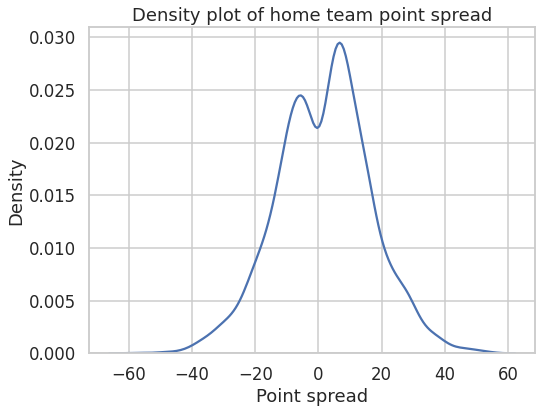

In [34]:
sns.kdeplot(df['HOME_PLUS/MINUS'])
plt.title('Density plot of home team point spread')
plt.xlabel('Point spread');


Here we see that the point spreads are relatively balanced, with the home team being slightly more likely to win rather than lose. We can confirm this by calculating the average home point spread as well as looking at the likelihood that the home team will win. It is interesting that there is a depression in the density plot at 0 on the x-axis, indicating that ties are very unlikely (there are actually no ties in the NBA).

It is well known that there is a distinct homefield advantage in the NBA. Home teams win more often than the away team. Therefore, we will use home team win percentage as our baseline accuracy for classifying wins and losses. We will use the average point spread for the home team as our baseline prediction for regression.

In [35]:
print('Average home team point spread:', df['HOME_PLUS/MINUS'].mean().round(2))
print('Percent of victories by home team:', df['HOME_WIN'].value_counts(normalize=True).round(4)[1]*(100), '%')

Average home team point spread: 1.81
Percent of victories by home team: 55.52 %


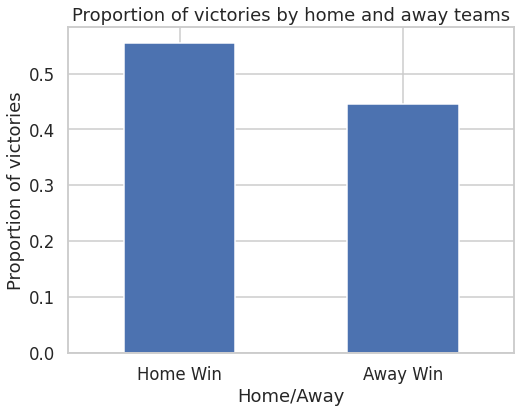

In [36]:
df['HOME_WIN'].value_counts(normalize=True).plot.bar(rot=0)
plt.xticks([0,1], labels=['Home Win', 'Away Win'])
plt.title("Proportion of victories by home and away teams")
plt.ylabel("Proportion of victories")
plt.xlabel("Home/Away");

Here we see that in an average game, the home team will win by 1.81 points, and home teams win on average 55.5% of the time. This is a good baseline prediction accuracy for win/loss and for point spread, as if we predict the home team will always win, we will be correct 55.5% of the time and if we assume all other stats are even, we will predict a home team victory of 1.81 points. 

# Machine learning

## Classification - Predicting wins


### Data Preparation and Baseline Accuracy

In order to prepare our data for classification, we must identify our predictor and target variables and perform a train-test split. For our classification problems, the target variable will be 'HOME_WIN' indicating whether the home team won or not. The predictor variables will be all the box score and advanced metrics for each team as well as the differential variables between the two teams.

In [37]:
predictors = ['HOME_PTS', 'HOME_FGM','HOME_FGA', 'HOME_FG%', 'HOME_3PM', 'HOME_3PA','HOME_3P%',
            'HOME_FTM', 'HOME_FTA', 'HOME_FT%', 'HOME_OREB', 'HOME_DREB','HOME_REB','HOME_AST',
            'HOME_STL', 'HOME_BLK','HOME_TOV', 'HOME_PF',  'HOME_OFFRTG', 'HOME_DEFRTG',
            'HOME_NETRTG','HOME_AST%', 'HOME_AST/TO', 'HOME_ASTRATIO', 'HOME_OREB%', 
            'HOME_DREB%', 'HOME_REB%','HOME_TOV%', 'HOME_EFG%', 'HOME_TS%', 'HOME_PACE', 
            'HOME_PIE','AWAY_PTS','AWAY_FGM', 'AWAY_FGA', 'AWAY_FG%', 'AWAY_3PM','AWAY_3PA',
            'AWAY_3P%', 'AWAY_FTM', 'AWAY_FTA', 'AWAY_FT%', 'AWAY_OREB', 'AWAY_DREB', 'AWAY_REB',
            'AWAY_AST', 'AWAY_STL', 'AWAY_BLK','AWAY_TOV','AWAY_PF',  'AWAY_OFFRTG', 'AWAY_DEFRTG',
            'AWAY_NETRTG','AWAY_AST%', 'AWAY_AST/TO', 'AWAY_ASTRATIO', 'AWAY_OREB%', 'AWAY_DREB%',
            'AWAY_REB%','AWAY_TOV%', 'AWAY_EFG%', 'AWAY_TS%','AWAY_PACE', 'AWAY_PIE', 'DIFF_PTS',
            'DIFF_FGM', 'DIFF_FGA', 'DIFF_FG%', 'DIFF_3PM','DIFF_3PA',
            'DIFF_3P%', 'DIFF_FTM', 'DIFF_FTA', 'DIFF_FT%', 'DIFF_OREB', 'DIFF_DREB', 'DIFF_REB',
            'DIFF_AST', 'DIFF_STL', 'DIFF_BLK','DIFF_TOV','DIFF_PF',  'DIFF_OFFRTG', 'DIFF_DEFRTG',
            'DIFF_NETRTG','DIFF_AST%', 'DIFF_AST/TO', 'DIFF_ASTRATIO', 'DIFF_OREB%', 'DIFF_DREB%',
            'DIFF_REB%','DIFF_TOV%', 'DIFF_EFG%', 'DIFF_TS%','DIFF_PACE', 'DIFF_PIE']

target = 'HOME_WIN'

X = df[predictors].values
y = df[target].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
print("Training set length:", len(X_train))
print("Test set length:", len(X_test))

Training set length: 1929
Test set length: 827


Here we see that our training set will have 1929 rows, more than enough to perform reliable classifications.

Next, we can calculate a baseline test accuracy using the mode of the target test data. This accuracy value is likely to be slightly different than the average proportion of the time the home team wins overall (0.555) since we are now only analyzing the test data.

In [40]:
baselinec_pred = pd.Series(y_test).mode()
baselinec_pred_ar = np.array([baselinec_pred] * len(y_test))[:,0]
baselinec_accuracy = (baselinec_pred_ar == y_test).mean()
print("Baseline Accuracy:", baselinec_accuracy.round(3))

Baseline Accuracy: 0.549


We see a baseline accuracy of 0.549. Our machine learning models can be compared to this baseline accuracy to assess their performance. 

### Decision Tree

Before constructing a decision tree, it is important to optimize hyperparameters. Decision trees have a large amount of hyperparameters, and it is time consuming to perform every combination. Therefore, we will focus on the 'max_depth' parameter, which dictates how many levels a tree can have and controls overfitting. We will test values between 1 and 20. Note this code will take about 30 seconds to run.

In [41]:
grid = [ {'max_depth': range(1,21)} ]
tree_cv = GridSearchCV(DecisionTreeClassifier(), grid, cv=10, scoring='accuracy', refit=True)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(1, 21)}], scoring='accuracy')

In [42]:
print("Best max depth:", tree_cv.best_params_['max_depth'])

Best max depth: 3


In [43]:
print("Cross-validation accuracy:", tree_cv.best_score_.round(3))

Cross-validation accuracy: 0.654


We see that the optimal max_depth based on cross-validation for our tree is 3 and that the cross-validation accuracy of this model is 0.654. However, it is important to assess the other hyperparameter values that our grid search tested. We will plot each max_depth value against its cross-validation accuracy.

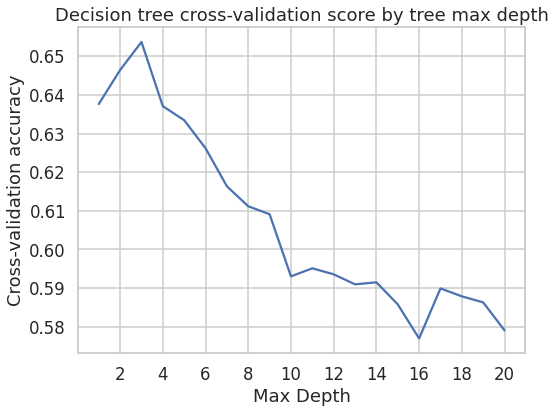

In [44]:
tree_results = pd.DataFrame(tree_cv.cv_results_)
sns.lineplot(data=tree_results, x ='param_max_depth', y='mean_test_score')
plt.title("Decision tree cross-validation score by tree max depth")
plt.xlabel("Max Depth")
plt.ylabel("Cross-validation accuracy")
plt.xticks(range(2,21,2));

We see that there is an increase of more than 1% for trees of depth 3 compared to shallower and deeper trees. Therefore, we will proceed with building a tree of depth 3.

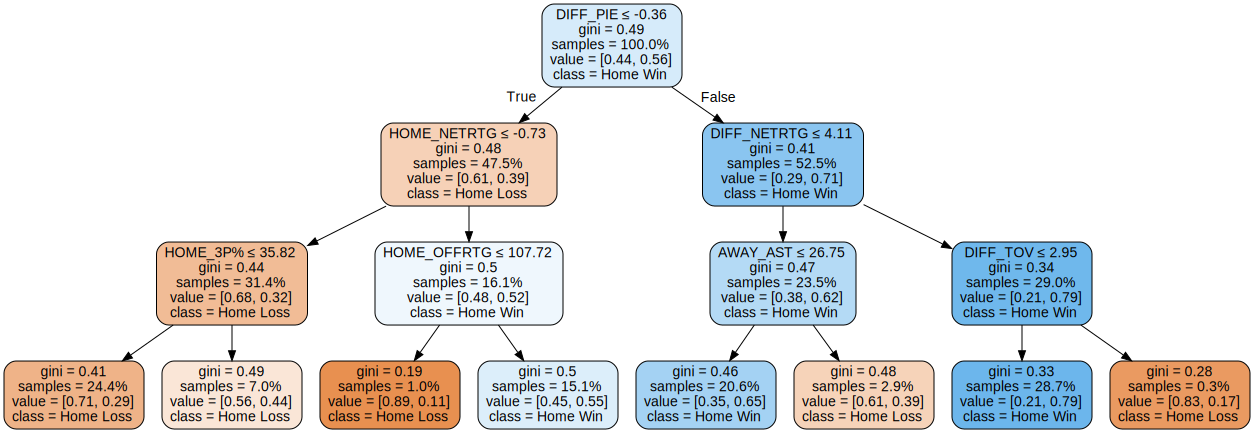

In [45]:
plot_tree_custom(tree_cv)

Our tree indicates that 7 variables are involved in deciding whether the home team will win or lose. PIE stands for Player Impact Estimate, an advanced metric dictating what proportion of stats from each game each team is involved in. The next level of variables refers to 'NETRTG' which is the average points scored over 100 possessions minus the average points allowed over 100 possessions. The other 3 variables involved in the tree are more straightforward: '3P%' is the percent of three-pointers made, 'AST' is the number of assists, and 'TOV' is the number of turnovers.

Next, we look at the relative importances of the features used to create this tree. Since only seven features were included in the tree, we limit our plotting to the top seven features. 

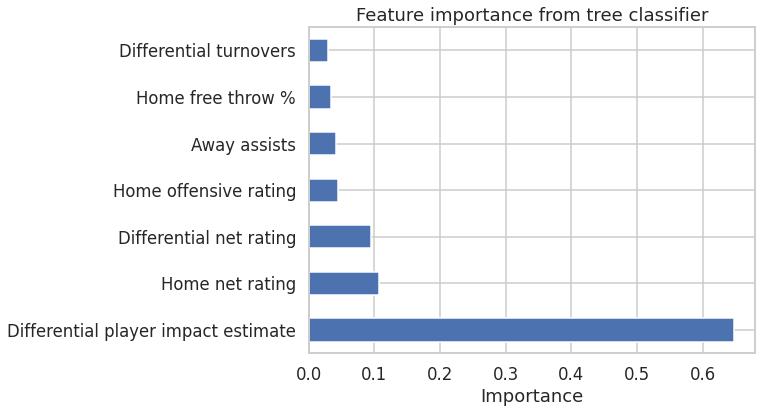

In [46]:
labels = [vars[x] for x in vars]
pd.Series(tree_cv.best_estimator_.feature_importances_, index=labels).sort_values(ascending=False)[:7].plot.barh()
plt.title("Feature importance from tree classifier")
plt.xlabel("Importance");

It is clear that the player impact estimate is the most important variable. This variable is described above. Net rating (also described above) is minorly important, as are some more straightforward features such as assists, free throw percentage, and turnovers. 

We can also look at the learning curve for this tree to determine if we are in a high bias or high variance situation.

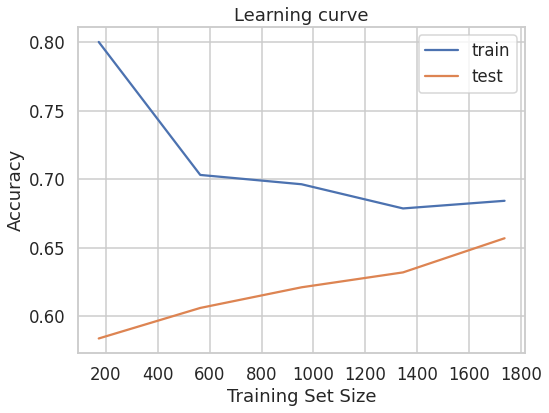

In [47]:
plot_learning_curve(tree_cv.best_estimator_, X_train, y_train)

The test and training accuracies converge slowly, indicating that we are not in a high bias situation. There is a small gap between the trainind and test data, even at high training sizes. However, this gap is less than 3%, so its not cause for too much concern.

#### Test Accuracy

As a final step, we will produce our test accuracy and confusion matrix using the best-fitted estimator and the test data.

In [48]:
treec_accuracy = tree_cv.best_estimator_.score(X_test, y_test)
print("Test accuracy:", treec_accuracy.round(3))


Test accuracy: 0.626


In [49]:
y_pred = tree_cv.best_estimator_.predict(X_test)
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='all')

             predicted     
actual    Home WinHome Loss
Home Win     0.227    0.224
Home Loss     0.15    0.399


We also compute a confusion matrix, normalizing for our predicted values.

In [50]:
y_pred = tree_cv.best_estimator_.predict(X_test)
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='pred')

             predicted     
actual    Home WinHome Loss
Home Win     0.603    0.359
Home Loss    0.397    0.641


Here we see a test accuracy of 0.626 (compared to 0.555 for baseline). This model is marginally better than the baseline accuracy of always predicting a home team victory. Additionally, we see that a majority of our correct predictions were home losses (0.399). We also see that the decision tree is marginally better at predicting losses (correct 64.1% of the time) compared to wins (correct 60.3% of the time).

### K-Nearest Neighbor (KNN)

Our decision tree was only marginally better at predicting wins and losses compared to our baseline accuracy, so we will also train a KNN classifier to predict wins and losses.

For KNN, we must scale our data and perform a new train-test split on the scaled data.

In [51]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=42)

It is important to consider that additional features that are not helpful in making predictions may harm a KNN machine learning algorithm. Our dataset has 96 features, all of which are likely not helpful for machine learning. Therefore, we use forward feature selection to select the n best features to use. 

We will first perform a grid search on the k-value, distance formula (p), and whether or not to use weighted or uniform distance weighing for our initial sequential feature selection object. Note this code takes about 1 minute to run.

In [53]:
grid = [ {'n_neighbors':range(1,51,1), 'weights':['uniform', 'distance'], 'p':[1,2]} ]
knn_cv = GridSearchCV(KNeighborsClassifier(), grid, cv=10, scoring='accuracy', refit=True)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': range(1, 51), 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [54]:
print("Best k:", knn_cv.best_params_['n_neighbors'])
print("Best distance formula:", knn_cv.best_params_['p'])
print("Best distance weights:", knn_cv.best_params_['weights'])

Best k: 34
Best distance formula: 2
Best distance weights: uniform


In [55]:
print("Cross-validation accuracy with all features:", knn_cv.best_score_.round(3))

Cross-validation accuracy with all features: 0.665


We see that our highest cross-validation accuracy was 0.665 when k was 34, euclidean distance was used (p = 2), and distanced were unweighted.

Now, we initiate forward feature selection for 1 to 15 features. For each output, we perform a grid search to determine the best hyperparameters. This code is exhaustive and greedy, which is why we limit our search to up to 15 features and only consider the 'n_neighbors' parameter for our KNN classifier up to k=40. Note that we use our best estimator from the first grid search to initially make the sequential feature selector. This code takes about 20 minutes to run.

In [56]:
score = []
i_list = []
params = []
for i in range(1,16):
  knn_sfs = SequentialFeatureSelector(knn_cv.best_estimator_, n_features_to_select=i)
  knn_sfs.fit(X_train, y_train)
  X_train_sfs = X_train[:, knn_sfs.get_support(indices=True)]
  X_test_sfs = X_test[:, knn_sfs.get_support(indices=True)]
  grid = [ {'n_neighbors':range(1,41)} ]
  knn_cv_sfs = GridSearchCV(KNeighborsClassifier(), grid, cv=5, scoring='accuracy', refit=True)
  knn_cv_sfs.fit(X_train_sfs, y_train)
  score.append(knn_cv_sfs.best_score_)
  params.append(knn_cv_sfs.best_params_)
  i_list.append(i)

In order to visualize the output, we will plot each iteration of the for loop (i.e. each number of features from sequential feature selection) against the grid search's best cross-validation accuracy for that number of features. 

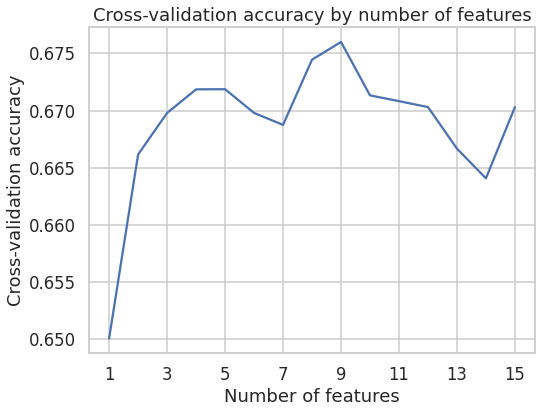

In [57]:
sns.lineplot(x=i_list, y=score)
plt.title("Cross-validation accuracy by number of features")
plt.xlabel("Number of features")
plt.ylabel("Cross-validation accuracy")
plt.xticks(range(1, 16, 2));

It is clear that the optimal number of features is 9. It is however, important to note that this search was non-exhaustive, as running the code with more than 15 features would be too time consuming. We also check the k-value for this estimator. 

In [58]:
print("k value for KNN with 9 features:", params[8]['n_neighbors'])

k value for KNN with 9 features: 33


Next, we fit the sequential feature selector with 9 features since this is the optimal number of features. Note this code takes 1-2 minutes to run.

In [59]:
knn_sfs = SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=33), n_features_to_select=9)
knn_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=33),
                          n_features_to_select=9)

In order to fit a KNN classifier with the new set of features, we must first make a new training and test set with just the 9 features we want. 

In [60]:
X_train_sfs = X_train[:, knn_sfs.get_support(indices=True)]
X_test_sfs = X_test[:, knn_sfs.get_support(indices=True)]

We will now run another grid search with the 9 features we want in order to ensure we pick the best hyperparameters by which to fit our KNN classifier. Note this code takes around 1 minute to run.

In [61]:
grid = [ {'n_neighbors':range(1,51,1), 'p':[1,2], 'weights':['uniform', 'distance']} ]
knn_cv_sfs = GridSearchCV(KNeighborsClassifier(), grid, cv=10, scoring='accuracy', refit=True)
knn_cv_sfs.fit(X_train_sfs, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': range(1, 51), 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [62]:
print("Best k:", knn_cv_sfs.best_params_['n_neighbors'])
print("Best distance formula:", knn_cv_sfs.best_params_['p'])
print("Best distance weights:", knn_cv_sfs.best_params_['weights'])

Best k: 33
Best distance formula: 1
Best distance weights: distance


Here we see that a k-value of 33 is still optimal, we should be using manhattan distance formula (p=1) and distances should be weighted.

We can also plot the k-values and their cross-validation accuracies:

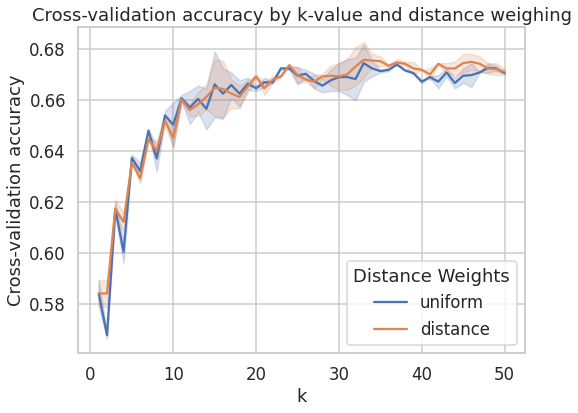

In [63]:
knn_sfs_results = pd.DataFrame(knn_cv_sfs.cv_results_)
sns.lineplot(data=knn_sfs_results, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
plt.title("Cross-validation accuracy by k-value and distance weighing")
plt.xlabel("k")
plt.ylabel("Cross-validation accuracy")
plt.legend(title="Distance Weights");

There is some amount of variation, but a k-value of 33 and distance-based weighing are optimal parameters (along with manhattan distance formula).

Finally, we can compare cross validation accuracies of our optimal classifier with the 9 best features against our optimal classifier including all the features.

In [64]:
print("Cross-validation accuracy of 9 best features:", knn_cv_sfs.best_score_.round(3))

Cross-validation accuracy of 9 best features: 0.683


In [65]:
print("Cross-validation accuracy with all features:", knn_cv.best_score_.round(3))

Cross-validation accuracy with all features: 0.665


#### Test Accuracy

Our classifier with only 9 features performs 3% better than our classifier using all the features. Therefore, we will use this classifier in calculating our test accuracy.

In [66]:
knnc_accuracy = knn_cv_sfs.best_estimator_.score(X_test_sfs, y_test)
print("Test accuracy:", knnc_accuracy.round(3))

Test accuracy: 0.641


In [67]:
y_pred = knn_cv_sfs.best_estimator_.predict(X_test_sfs)

In [68]:
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='all')

             predicted     
actual    Home WinHome Loss
Home Win     0.245    0.206
Home Loss    0.154    0.395


In [69]:
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='pred')

             predicted     
actual    Home WinHome Loss
Home Win     0.615    0.342
Home Loss    0.385    0.658


With a test accuracy of 0.641, the KNN classifier is slightly better than the decision tree (accuracy of 0.626) and baseline accuracy (0.555). Like with the decision tree, the KNN classifier is slightly better at predicting losses (0.658 success rate) than wins (0.615 success rate)

### Logistic Regression

The next classifying algorithm we will use is logistic regression, which requires no hyperparameters to tune. However, we do have to scale the data

In [70]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We can now train and fit our linear regression algorithm. This code takes 1 minute to run since we manually set the max number of iterations to 2500 so that the model would converge.

In [72]:
log = LogisticRegression(max_iter=2500)
log.fit(X_train, y_train)
print("Cross Validation Accuracy:", cross_val_score(log, X_train, y_train, cv=10).mean().round(3))

Cross Validation Accuracy: 0.673


We get a cross-validation accuracy of 0.673, comparable to what we were getting with our other classifiers.

We can look at the coefficient values to assess the most important predictors for logistic regression.

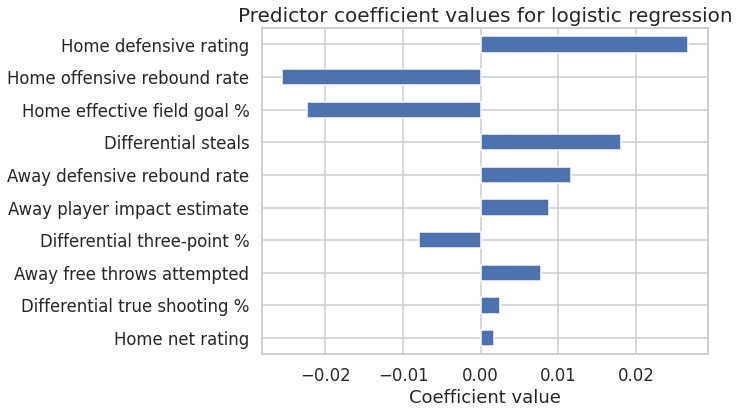

In [73]:
labels = [vars[x] for x in vars]
pd.Series(log.coef_[0,:], index=labels).sort_values(key=abs)[:10].plot.barh()
plt.xlabel("Coefficient value")
plt.title("Predictor coefficient values for logistic regression", size=20);

Despite having similar cross-validation accuracies, the most important features for logistic regression are vastly different than those important to the decision tree. Here, there is no feature that is vastly more important than the others. Defensive rating is the number of points allowed per 100 defensive possesions. Rebound rate is the rate at which a team gets a rebound (specific to offensive and defensive rebounds). Effective field goal (EFG) percentage and trust shooting (TS) percentage are advanced offensive metrics. EFG% weighs three pointers more heavily than traditional FG% since they are worth more points. TS% takes free throws into account as well. Steals and free throw attempts are self explanatory, and net rating and player impact estimate were described in the decision tree portion of this report.

#### Test Accuracy

Now, we can compute our test accuracy with our logistic regression algorithm, since there are no hyperparameters to tune.

In [74]:
log_accuracy = log.score(X_test, y_test)
print("Test Accuracy:", log_accuracy.round(3))

Test Accuracy: 0.643


In [75]:
y_pred = log.predict(X_test)
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='all')

             predicted     
actual    Home WinHome Loss
Home Win     0.254    0.197
Home Loss     0.16    0.389


In [76]:
print_conf_mtx(y_test, y_pred, classes=["Home Win", "Home Loss"], norm='pred')

             predicted     
actual    Home WinHome Loss
Home Win     0.614    0.336
Home Loss    0.386    0.664


Like both our decision tree and k-nearest neighbor classifier, our logistic regression algorithm is slightly better at predicting home losses (0.664 accuracy) than wins (0.614 accuracy). The overall accuracy of this algorithm (0.643 success rate) is very nearly the same as the KNN classifier (accuracy of 0.641), and slightly better than the decision tree (0.626 accuracy) and the baseline accuracy (0.555).

### Linear Regression to Classification

Our final classification algorithm is a linear regression algorithm that predicts the point spread of the home team. If the predicted spread is positive, our algorithm will predict a win for the home team. If it is negative, it will predict a loss. 

We identify a new target variable and rescale and split the data. We make sure to use the same random_state for both the regression and classification y-data. This way, we can compare our predictions to the split classification y-data. 

In [77]:
target = 'HOME_PLUS/MINUS'

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

X = df[predictors].values
y = df[target].values
y_clf = df['HOME_WIN'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [78]:
clf_X_train, clf_X_test, clf_y_train, clf_y_test = train_test_split(X, y_clf, test_size=0.3, random_state=42)

Now we fit a linear regression algorithm and compile a list of classification predictions from our linear regression. 

In [79]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [80]:
win_pred = []
y_pred = regr.predict(X_test)
for i in range(len(y_pred)):
  if (y_pred[i] > 0):
    win_pred.append(1)
  else:
    win_pred.append(0)

Now that we have compiled a list of predictions, we can compare this list to the classification target test data to compute a test accuracy.

In [81]:
lc_accuracy = (win_pred == clf_y_test).mean()
print("Linear Classification Test Accuracy", lc_accuracy.round(3))

Linear Classification Test Accuracy 0.626


Our linear test accuracy exhibits an accuracy of 0.626. This compares to 0.643 for logistic regression, 0.641 for KNN, 0.626 for the decision tree, and an 0.555 baseline accuracy.

### Classification Model Comparison

It is important to determine why model performs the best using this dataset. Therefore, we visualize the test accuracies from the optimized version of each model as well as the baseline accuracy. 

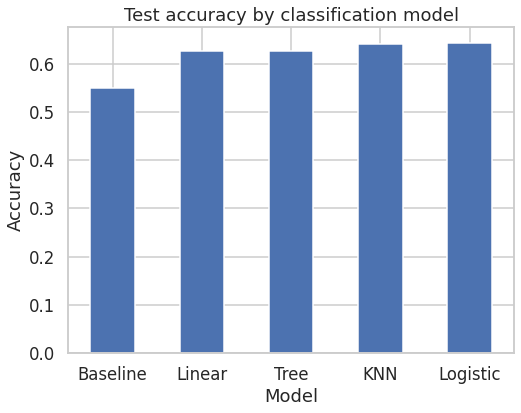

In [82]:
test_accuracy = [baselinec_accuracy, lc_accuracy, log_accuracy, knnc_accuracy, treec_accuracy]
test_accuracy_index = ['Baseline', 'Linear', 'Logistic', 'KNN', 'Tree']

accuracy_comp = pd.Series(test_accuracy, index=test_accuracy_index)

accuracy_comp.sort_values().plot.bar(rot=0)
plt.title("Test accuracy by classification model")
plt.xlabel("Model")
plt.ylabel("Accuracy");

In [83]:
print("Test Accuracies")
print(accuracy_comp)

Test Accuracies
Baseline    0.548972
Linear      0.626360
Logistic    0.643289
KNN         0.640871
Tree        0.626360
dtype: float64


It is clear that all of our models perform significantly better than the baseline model. Surprisingly, the model extrapolated from a linear regression performs the worst and logistic regression performs the best. Since linear and logistic regression are closely related, we would expect these models to exhibit similar accuracies. Differences in accuracy between our best model (0.643) and our worst (0.626) was about 2%, and this difference may be attributed to randomness. It is unclear whether we can establish that any of these models are definitively better than the others. This was confirmed because when testing the models using different random states for our train-test split, test accuracies varied by ~4%, indicating that these differences likely involve a significant level of randomness.

## Regression - Predicting point spread

Another, perhaps more powerful machine learning problem that this dataset provides is to predict point spread. In this case, we will refer to point spread as the home team's point spread (i.e. if the point spread is positive, the home team wins). 

### Data Preparation and Baseline RMSE

First, we will remake our predictor variable dataset and make our target variable 'HOME_PLUS/MINUS'. We also perform a train-test split on this data. Note that we will always use random_state=42 for our models so that their scores can be compared.

In [84]:
predictors = ['HOME_PTS', 'HOME_FGM','HOME_FGA', 'HOME_FG%', 'HOME_3PM', 'HOME_3PA','HOME_3P%',
            'HOME_FTM', 'HOME_FTA', 'HOME_FT%', 'HOME_OREB', 'HOME_DREB','HOME_REB','HOME_AST',
            'HOME_STL', 'HOME_BLK','HOME_TOV', 'HOME_PF',  'HOME_OFFRTG', 'HOME_DEFRTG',
            'HOME_NETRTG','HOME_AST%', 'HOME_AST/TO', 'HOME_ASTRATIO', 'HOME_OREB%', 
            'HOME_DREB%', 'HOME_REB%','HOME_TOV%', 'HOME_EFG%', 'HOME_TS%', 'HOME_PACE', 
            'HOME_PIE','AWAY_PTS','AWAY_FGM', 'AWAY_FGA', 'AWAY_FG%', 'AWAY_3PM','AWAY_3PA',
            'AWAY_3P%', 'AWAY_FTM', 'AWAY_FTA', 'AWAY_FT%', 'AWAY_OREB', 'AWAY_DREB', 'AWAY_REB',
            'AWAY_AST', 'AWAY_STL', 'AWAY_BLK','AWAY_TOV','AWAY_PF',  'AWAY_OFFRTG', 'AWAY_DEFRTG',
            'AWAY_NETRTG','AWAY_AST%', 'AWAY_AST/TO', 'AWAY_ASTRATIO', 'AWAY_OREB%', 'AWAY_DREB%',
            'AWAY_REB%','AWAY_TOV%', 'AWAY_EFG%', 'AWAY_TS%','AWAY_PACE', 'AWAY_PIE', 'DIFF_PTS','DIFF_FGM', 'DIFF_FGA', 'DIFF_FG%', 'DIFF_3PM','DIFF_3PA',
            'DIFF_3P%', 'DIFF_FTM', 'DIFF_FTA', 'DIFF_FT%', 'DIFF_OREB', 'DIFF_DREB', 'DIFF_REB',
            'DIFF_AST', 'DIFF_STL', 'DIFF_BLK','DIFF_TOV','DIFF_PF',  'DIFF_OFFRTG', 'DIFF_DEFRTG',
            'DIFF_NETRTG','DIFF_AST%', 'DIFF_AST/TO', 'DIFF_ASTRATIO', 'DIFF_OREB%', 'DIFF_DREB%',
            'DIFF_REB%','DIFF_TOV%', 'DIFF_EFG%', 'DIFF_TS%','DIFF_PACE', 'DIFF_PIE']

target = 'HOME_PLUS/MINUS'

X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

After splitting the data into training and test data, we will calculate our baseline RMSE using the test data. The baseline root mean squared error (RMSE) gives us the RMSE of the average of our target variable ('HOME_PLUS/MINUS).

In [85]:
baseliner_prediction = y_test.mean()
baseliner_rmse = np.sqrt(((baseliner_prediction - y_test)**2).mean())
print("Baseline point spread prediction:", baseliner_prediction.round(3))
print('Baseline RMSE: {:.3f}'.format(baseliner_rmse))

Baseline point spread prediction: 1.576
Baseline RMSE: 14.805


These results indicate that in an average game, the home team will win by 1.58 points. The average error for this is 14.81 points. These data are different than the initial baseline accuracies because we are only using the test data here. 

### Linear Regression

For linear regression, we will first scale our data so that coefficient values can be compared. We also compute a train-test split with the scaled data. 

In [86]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=42)

Next, we train and fit our linear regression algorithm

In [88]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

We can identify the 10 most important features by sorting the coefficients by absolute value. 

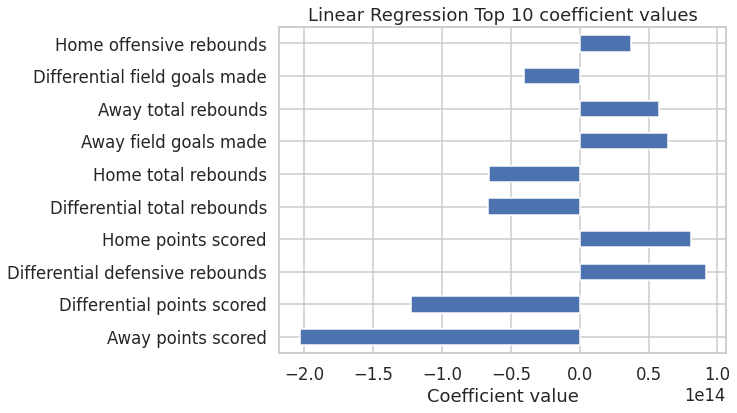

In [89]:
labels = [vars[x] for x in vars]
pd.Series(regr.coef_, index=labels).sort_values(key=abs, ascending=False)[:10].plot.barh()
plt.title("Linear Regression Top 10 coefficient values")
plt.xlabel("Coefficient value");

It is important to note that some of these coefficients are not intuitive. For example, you would not expect the home team scoring more average points (differential points scored) to be a negative predictor of home point spread. However, the complexity of linear models with many parameters can cause this to happen. 

The most important features for our linear model have to do with points scored, rebounds, and field goals (shots) made. Surprisingly, none of the advanced metrics are as important as they were in our classification models.

#### Test RMSE

After fitting our model, we can test it on our testing data by calculating the RMSE. 

In [90]:
y_pred = regr.predict(X_test)
lr_rmse =np.sqrt(((y_pred - y_test)**2).mean())
print('Test RMSE: {:.2f}'.format(lr_rmse))

Test RMSE: 14.17


With an RMSE of 14.17, the linear model is only slightly better than our baseline model (RMSE = 14.805).

We can also plot our predicted versus actual point spreads to see whether our model is over or underestimating point spreads. 

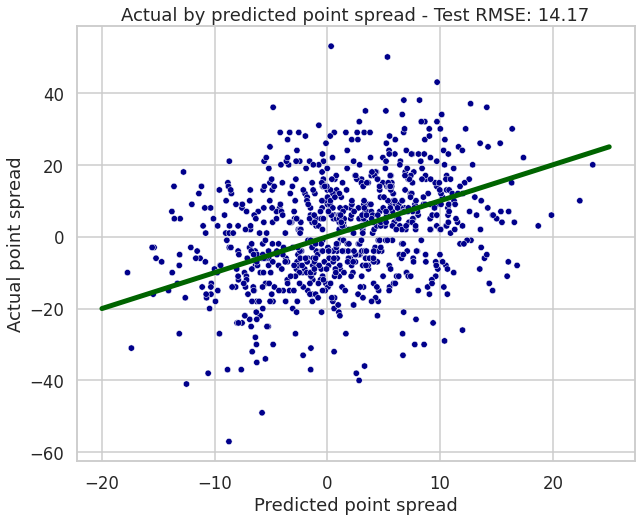

In [91]:
y_pred = regr.predict(X_test)
plt.figure(figsize=(10,8))
sns.scatterplot(x=y_pred, y=y_test, color='darkblue', size=4, legend=None)
plt.plot(np.linspace(-20, 25), np.linspace(-20, 25), c='darkgreen', linewidth=5)
plt.xlabel("Predicted point spread")
plt.ylabel("Actual point spread")
plt.title("Actual by predicted point spread - Test RMSE: 14.17");

Our linear models predictions increase as actual point spread increases, however the variance seen is massive. The scale of predictions (22 point maximum) is much smaller than the scale of actual point spreads (almost 60 point maximum). It is interesting to point out that our model predicts ties, whereas ties are never seen in the actual data. This would be an additional factor to consider in developing these models further. 

### K-Nearest Neighbor Regression

First, we scale our data and run a fresh train-test split on the scaled data.


In [92]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=42)

Using a grid search, we can determine the optimal values for k, distance formula, and weighted distances. Note this code will take about 1 minute to run.

In [94]:
grid = [ {'n_neighbors':range(1,51,1), 'p':[1,2], 'weights':['uniform', 'distance']} ]
knnr_cv = GridSearchCV(KNeighborsRegressor(), grid, scoring='neg_root_mean_squared_error', cv=10, refit=True)
knnr_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': range(1, 51), 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             scoring='neg_root_mean_squared_error')

In [95]:
print("Best k:", knnr_cv.best_params_['n_neighbors'])
print("Best distance formula:", knnr_cv.best_params_['p'])
print("Best distance weights:", knnr_cv.best_params_['weights'])

Best k: 50
Best distance formula: 1
Best distance weights: distance


Here we see that a k-value of 50 is still optimal, we should be using manhattan distance formula (p=1) and distances should be weighted.

In [96]:
print("Cross-validation root mean squared error:", -knnr_cv.best_score_.round(3))

Cross-validation root mean squared error: 13.691


Here the lowest cross-validation accuracy was 13.691 when k was 50, manhattan distance was used (p = 1), and distances were weighted.

As with KNN classification, unhelpful predictors may decrease our model's performance. Therefore we initiate forward feature selection for 1 to 15 features. For each output, we perform a grid search to determine the best hyperparameters. This code greedy, so we limit our search to up to only 15 features and only consider the 'n_neighbors' parameter for our KNN classifier up to k=50. Note that we use our best estimator from the first grid search to initially make the sequential feature selector. This code takes about 12 minutes to run.

In [97]:
score = []
i_list = []
params = []
for i in range(1,16):
  knnr_sfs = SequentialFeatureSelector(knnr_cv.best_estimator_, n_features_to_select=i)
  knnr_sfs.fit(X_train, y_train)
  X_train_sfs = X_train[:, knnr_sfs.get_support(indices=True)]
  X_test_sfs = X_test[:, knnr_sfs.get_support(indices=True)]
  grid = [ {'n_neighbors':range(1,51)} ]
  knnr_cv_sfs = GridSearchCV(KNeighborsRegressor(), grid, cv=5, scoring='neg_root_mean_squared_error', refit=True)
  knnr_cv_sfs.fit(X_train_sfs, y_train)
  score.append(knnr_cv_sfs.best_score_)
  params.append(knnr_cv_sfs.best_params_)
  i_list.append(i)

Here we are visulizing the plot , cross-validiation accuracy by number of features

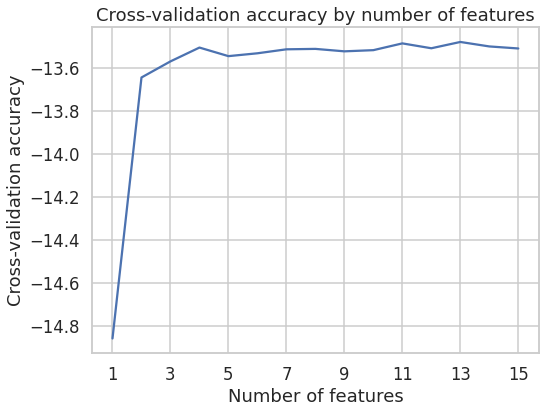

In [98]:
sns.lineplot(x=i_list, y=score)
plt.title("Cross-validation accuracy by number of features")
plt.xlabel("Number of features")
plt.ylabel("Cross-validation accuracy")
plt.xticks(range(1, 16, 2));

As you can see the optimal number of features is 13. However, the differences in RMSE between 4 and 15 features is marginal. Since 13 is our optimal number of features (though any number between 4 and 15 would probably work similarly), we will move forward using the 13 best features. We also check the k-value that grid search optimized for this estimator.

In [99]:
print("k value for KNN with 13 features:", params[12]['n_neighbors'])

k value for KNN with 13 features: 41


We see that the optimal number of neighbors is 41 for 13 features. Next, we can refit the sequential feature selector with 13 features and a k-value of 41. Note this code takes 1-2 minutes to run.

In [100]:
knnr_sfs = SequentialFeatureSelector(estimator=KNeighborsRegressor(n_neighbors=41), n_features_to_select=13)
knnr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=KNeighborsRegressor(n_neighbors=41),
                          n_features_to_select=13)

Next, we make a new training and test set with just 13 features

In [101]:
X_train_sfs = X_train[:, knnr_sfs.get_support(indices=True)]
X_test_sfs = X_test[:, knnr_sfs.get_support(indices=True)]

We now run another gridsearch with 13 features to get the best hyperparameters.

In [102]:
grid = [ {'n_neighbors':range(1,51,1), 'p':[1,2], 'weights':['uniform', 'distance']} ]
knnr_cv_sfs = GridSearchCV(KNeighborsRegressor(), grid, cv=10, scoring='neg_root_mean_squared_error', refit=True)
knnr_cv_sfs.fit(X_train_sfs, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': range(1, 51), 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             scoring='neg_root_mean_squared_error')

In [103]:
print("Best k:", knnr_cv_sfs.best_params_['n_neighbors'])
print("Best distance formula:", knnr_cv_sfs.best_params_['p'])
print("Best distance weights:", knnr_cv_sfs.best_params_['weights'])

Best k: 50
Best distance formula: 1
Best distance weights: distance


Interestingly, 50 is the best k-value (compared to 41). Additionally, we should use manhattan distance formula(p=1) and distance is weighted.

We can now plot our cross-validation RMSEs and their k-values for the 13 feature dataset.

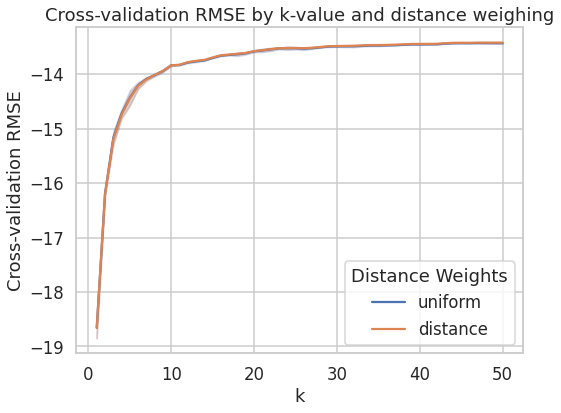

In [104]:
knnr_sfs_results = pd.DataFrame(knnr_cv_sfs.cv_results_)
sns.lineplot(data=knnr_sfs_results, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
plt.title("Cross-validation RMSE by k-value and distance weighing")
plt.xlabel("k")
plt.ylabel("Cross-validation RMSE")
plt.legend(title="Distance Weights");

There isn't much varation of RMSEs for k values between 20 and 50. However, 50 is the optimal k-value so we will fit our model with it. Additionally, one can see that there is not a large difference between uniform and distance weighing, but distance weighing is slightly better.

In order to compare the regression model with 13 features and all our model using all of the features, we use cross-validation RMSE.

In [105]:
print("Cross-validation RMSE of 13 best features:", -knnr_cv_sfs.best_score_.round(3))

Cross-validation RMSE of 13 best features: 13.405


In [106]:
print("Cross-validation RMSE with all features:", -knnr_cv.best_score_.round(3))

Cross-validation RMSE with all features: 13.691


Our model using the 13 best features is slightly better, so we will use it when running the model on the test data.

#### Test RMSE

Since with only 13 features performs better than using all features. Hence, we use this model to calculate the test accuracy 

In [107]:
y_pred = knnr_cv_sfs.predict(X_test_sfs)
knnr_rmse = np.sqrt(((y_pred - y_test)**2).mean())
print('Test RMSE: {:.3f}'.format(knnr_rmse))

Test RMSE: 13.774


Here we see a test RMSE of 13.774 (compared to 14.805 for baseline). This model is marginally better than the baseline accuracy for predicting point spread. It is also better than the linear regression test RMSE of 14.166. 

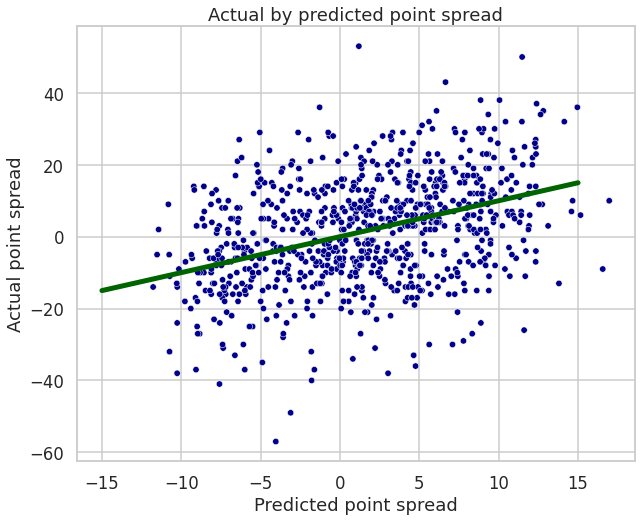

In [108]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=y_pred, y=y_test, color='darkblue', size=4, legend=None)
plt.plot(np.linspace(-15, 15), np.linspace(-15, 15), c='darkgreen', linewidth=5)
plt.xlabel("Predicted point spread")
plt.ylabel("Actual point spread")
plt.title("Actual by predicted point spread");

Similar to linear regression, the general trend for this model is correct, but there is a large variance in our predictions. Like linear regression, the model never makes predictions larger than ~17 point spread, whereas there are actual point spreads of almost 60 points. 

### Regression Tree

A regression tree operates similar to a classification tree, but instead predicts a point spread rather than a WIN or LOSS. We will start by doing a train/test split of the data. As well, we will be using a grid search to test a range of tree maximum depths from 1 to 15 to prevent overfitting and find the optimal max-depth of the tree.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
grid = [ {'max_depth': range(1,16)} ]
treer_cv = GridSearchCV(DecisionTreeRegressor(), grid, cv=10,scoring='neg_root_mean_squared_error', refit=True)
treer_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': range(1, 16)}],
             scoring='neg_root_mean_squared_error')

After the grid search has completed, the next step is to view and pick the best max_depth that will be result in the lowest RMSE value. To visualize this relationship, we plot cross validation RMSE values at each max depth. 

Text(0.5, 1.0, 'Cross-validation scores by tree maximum depth')

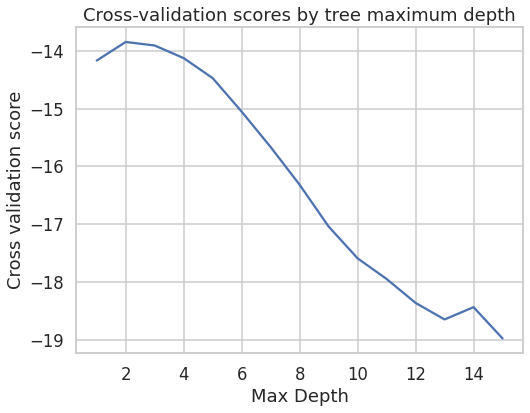

In [111]:
treer_results = pd.DataFrame(treer_cv.cv_results_)
sns.lineplot(x=treer_results['param_max_depth'], y=treer_results['mean_test_score'])
plt.xlabel("Max Depth")
plt.ylabel("Cross validation score")
plt.title("Cross-validation scores by tree maximum depth")

In [112]:
print("Best maximum depth:", treer_cv.best_params_['max_depth'])

Best maximum depth: 2


In [113]:
print("Cross-validation RMSE:", -cross_val_score(treer_cv.best_estimator_, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error').mean().round(3))

Cross-validation RMSE: 13.846


The plot shows that the best max_depth is 2 and the cross validation RMSE for this tree is 13.846. However, there is not a large difference between maximum depths 1, 2, or 3. Since RMSE decreases sharply as maximum depth increases, it is clear this model is susceptible to overfitting. Therefore, we will use a maximum depth of 2 on our final regression tree.

We plot our final tree below.

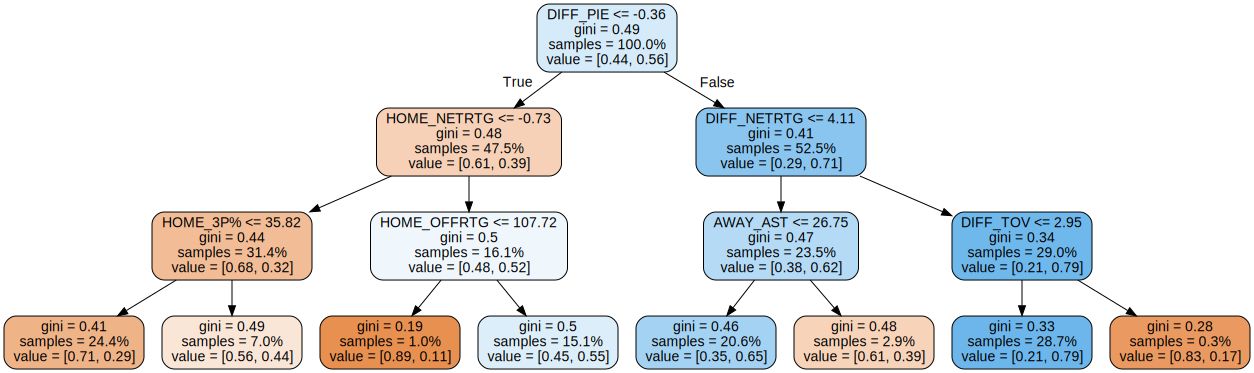

In [114]:
dot_data = export_graphviz(tree_cv.best_estimator_, precision=2,feature_names=predictors,proportion=True,filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

The tree chooses only 2 variables that fit our data best. Values more orange in color represent higher point spreads. There are a few things to point out here. First, there is only one value that represents a home loss. We know that home teams lose around 45% of the time. However, this tree only predicts a home loss 23.6% of the time. Additionally, the 'NET_RTG' variable is the only variable used here, both as a differential value (home - away) and as the home net rating. As a reminder, net rating is the average number of points scored per 100 possessions minus the average points allowed per 100 possessions. It is considered a good predictor of the success of a team, so it is unsurprising to see it represented here. 

To visualize the relative importance of the 2 variables seen in this tree, we plot the feature importances. 

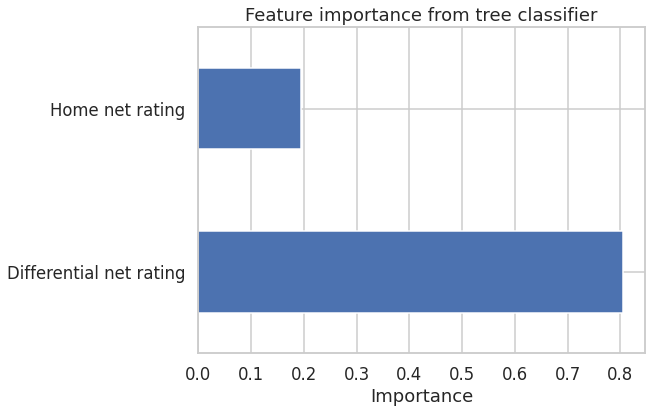

In [115]:
labels = [vars[x] for x in vars]
pd.Series(treer_cv.best_estimator_.feature_importances_, index=labels).sort_values(ascending=False)[:2].plot.barh()
plt.title("Feature importance from tree classifier")
plt.xlabel("Importance");

Here we see that the differential net rating is 4 times more important than the home team's net rating. This makes sense as the level 0 question in the tree relates to the differential net rating as does one of the questions in level 1 of the tree.

#### Test RMSE

The final step in analyzing our regression tree is to compute the test RMSE and plot the predicted and actual point spreads.

In [116]:
y_pred = treer_cv.predict(X_test)
treer_rmse = np.sqrt(((y_pred - y_test)**2).mean())
print('Test RMSE: {:.3f}'.format(treer_rmse))

Test RMSE: 14.068


Overall, he average error for this regression is 14.07 points which is the baseline RMSE of 14.8.

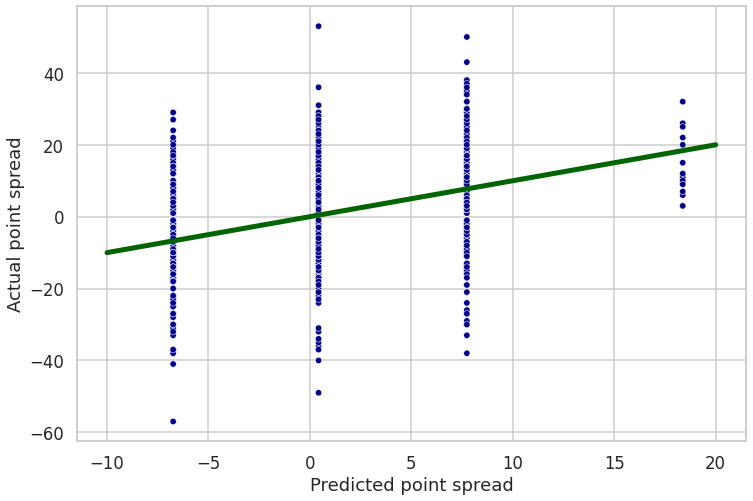

In [117]:
y_pred = treer_cv.predict(X_test)
plt.figure(figsize=(12,8))
sns.scatterplot(x=y_pred, y=y_test, color='darkblue', size=4, legend=None)
plt.plot(np.linspace(-10, 20), np.linspace(-10, 20), c='darkgreen', linewidth=5)
plt.xlabel("Predicted point spread")
plt.ylabel("Actual point spread");

Our model is definitely not overfitting, as there are only 4 possible predicted point spread, ranging from around -7 to 18. It is surprising that the test RMSE of this data is comparable to our other models (14.8 for baseline, 14.17 for linear regression, and 13.77 for KNN), since this data seems to fit terribly. 

### Regression Model Comparison 

As a final step, we compare the test RMSEs for our three regression models and the baseline RMSE.

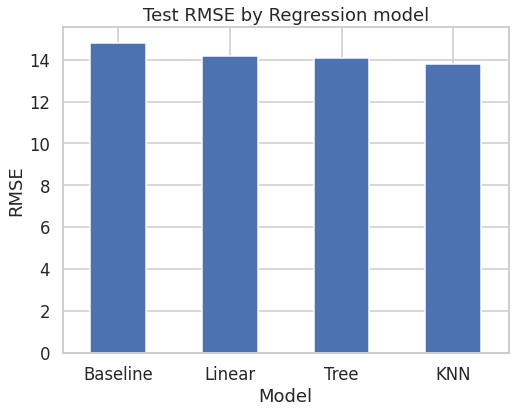

In [118]:
test_rmse = [baseliner_rmse, lr_rmse, knnr_rmse, treer_rmse]
test_rmse_index = ['Baseline', 'Linear', 'KNN', 'Tree']

rmse_comp = pd.Series(test_rmse, index=test_rmse_index)

rmse_comp.sort_values(ascending=False).plot.bar(rot=0)
plt.title("Test RMSE by Regression model")
plt.xlabel("Model")
plt.ylabel("RMSE");

In [119]:
print('Model RMSEs')
print(rmse_comp.sort_values(ascending=False))

Model RMSEs
Baseline    14.804899
Linear      14.165802
Tree        14.068164
KNN         13.774273
dtype: float64


All RMSEs are less than or very close to 1 point better than the baseline RMSE, indicating that these models are not very good at predicting point spread. As with our classification models, the differences between each model are marginal (less than 1 point) and may be due to randomness in the data. 

## Cluster Analysis

We decided it would be interesting to see how the team's average stats cluster using a principal component analysis. Since there are too many teams and games played to plot, we focus on the 2018-2019 season and plot the Eastern Conference teams separately from the Western Conference teams. 

First, we make a function that computes principal components for each game of each team as well as factor loadings. Note we multiply the factor loadings by 15 so that they can be plotted on the same axis as the principal components. 

In [120]:
eastern_conf = df_avg_2018[df_avg_2018['TEAM'].isin(['NYK', 'PHI', 'BKN', 'IND', 'CLE', 'CHI','TOR', 'BOS', 'MIL', 'ORL', 
       'ATL', 'MIA', 'WAS', 'CHA', 'DET'])]

western_conf = df_avg_2018[df_avg_2018['TEAM'].isin(['PHX', 'SAS', 'LAL', 'MEM', 'POR', 'GSW','UTA', 'NOP', 'SAC', 'MIN', 
       'DAL', 'HOU', 'DEN', 'LAC', 'OKC'])]

def prin_comp(df):
  X_cluster = df[['PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
   '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
   'TOV', 'PF', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'ASTRATIO', 
   'OREB%', 'DREB%', 'REB%','TOV%', 'EFG%', 'TS%', 'PACE', 'PIE']]
  target = df['TEAM'].reset_index(drop=True)
  scaler = StandardScaler()
  X_pca = scaler.fit_transform(X_cluster)
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(X_pca)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_cluster.columns.values)
  loadings['PC1'] = loadings['PC1']*15
  loadings['PC2'] = loadings['PC2']*15
  finalDf = pd.concat([principalDf, target], axis = 1).reset_index(drop=True)
  indicesToKeep = []
  for target2 in target:
    indicesToKeep = (target == target2)
  return finalDf, loadings

We then run the function for each conference.

In [121]:
final_east, loadings_east = prin_comp(eastern_conf)
final_west, loadings_west = prin_comp(western_conf)

Finally, we plot the principal components and factor loadings. 

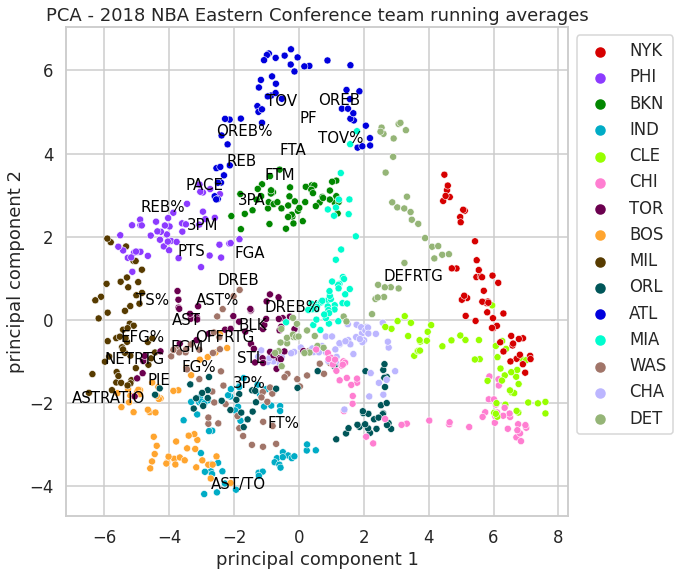

In [122]:
palette = sns.color_palette(cc.glasbey, n_colors=15)
plt.figure(figsize=(9,9))
sns.scatterplot(data = final_east, x='principal component 1', y='principal component 2', hue='TEAM', s = 50, palette = palette)
plt.legend(bbox_to_anchor=(1,1))
texts = []
for i in range(len(loadings_east['PC1'])):
  texts.append(plt.text(loadings_east['PC1'][i], loadings_east['PC2'][i], loadings_east.index[i], ha='center', va='center', fontsize=15, color='black'))
adjustText.adjust_text(texts)
plt.title('PCA - 2018 NBA Eastern Conference team running averages');


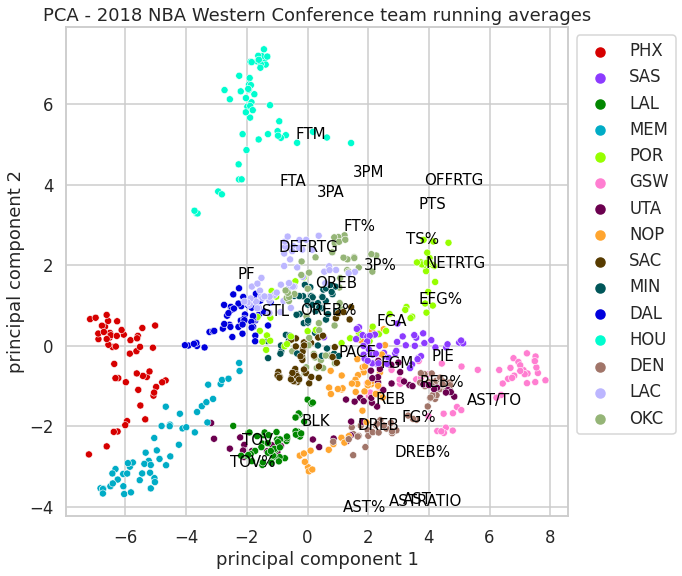

In [123]:
plt.figure(figsize=(9,9))
sns.scatterplot(data = final_west, x='principal component 1', y='principal component 2', hue='TEAM', s = 50, palette = palette)
plt.legend(bbox_to_anchor=(1,1))
texts = []
for i in range(len(loadings_west['PC1'])):
  texts.append(plt.text(loadings_west['PC1'][i], loadings_west['PC2'][i], loadings_west.index[i], ha='center', va='center', fontsize=15, color='black'))
adjustText.adjust_text(texts)
plt.title('PCA - 2018 NBA Western Conference team running averages');


Here we see definitive clustering for each team. Since the data consists of running averages, this makes sense, as the running average of each stat for each team is unlikely to change drastically from game to game. Had we plotted the PCA of each team's raw stats, the clustering would likely not be as pronounced. It is interesting to see which teams cluster near which features. This indicates that the variance seen in the data for that team is due to variance from those features. 

We see, for example, that Houston (Western Conference, bright blue) clusters far from the other teams, and is close to the three pointer and free throw features. It is a well known quality of the Houston Rockets to shoot a lot of three pointers and to 'flop', generating a high volume of free throws. Notice that Houston both shoots and makes a lot of three pointers and free throws, but do not have a drastically higher three point or free throw rate compared to other teams. 

## Anomaly Dectection

One of the main predictor variables, especially in our decision and regression trees, was differential net rating. Therefore, it is valueable to analyze the instances when a team played a close game despite having an an anomalously high or low differential net rating or a team played in a blow out despite having a relatively average differential net rating. 

In [124]:
features = ['DIFF_NETRTG', 'HOME_PLUS/MINUS']
X_scale = StandardScaler().fit_transform(df[features])
X = df[features].values

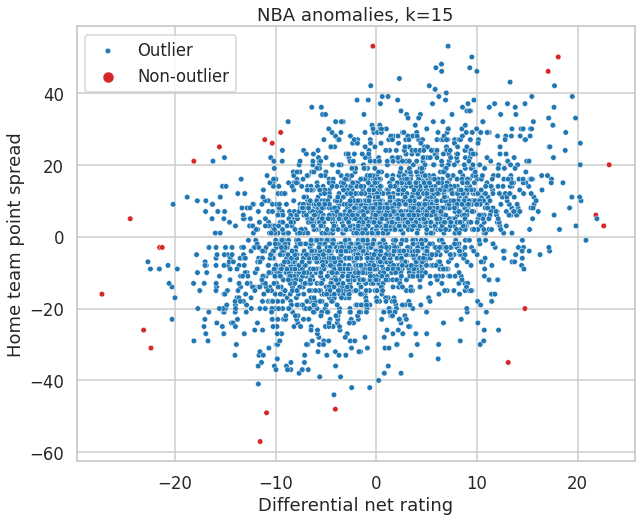

In [125]:
plt.figure(figsize=(10,8))
clf = LocalOutlierFactor(n_neighbors=15)
outliers = clf.fit_predict(X_scale)
sns.scatterplot(x=features[0], y=features[1], data=df, s=30, hue=outliers, palette=['tab:red', 'tab:blue'])
plt.title('NBA anomalies, k={}'.format(clf.n_neighbors))
plt.xlabel("Differential net rating")
plt.ylabel("Home team point spread")
plt.legend(labels=['Outlier', 'Non-outlier']);

In order to recognize unexpected data patterns, outlier detection is crucial. LOF measures how detached an object is from its surrounding neighbors rather than assuming that the outliers have a binary attribute.

We see here that outliers on the far left and right of the plot indicate instances when the home team had a much worse (left) or better (right) net rating than the away team, yet the two teams still played a close match. Outliers on the top and bottom of the plot indicate times when the home and away teams had similar average net ratings going into the game, but the game was a blowout, either in favor of the home team (top of plot) or away team (bottom of plot)



# Conclusion

In conclusion, our models were relatively better at predicting whether a team would win or lose than predicting the point spread. This makes sense, as a win or loss is a simply prediction than a point spread. For classification, all models were better than the baseline accuracy, ranging from 8 to 10% better than baseline accuracy (0.555). Our best model was a win/loss prediction based on a linear prediction of point spread. 

For regression, all models were marginally (0.7-1.0) points better than the baseline error. All models were extremely similar in their performance, with the best model (KNN), only having an error of 0.4 points better than the worse model (linear regression) This was likely due to randomness, as such a small difference is unlikely to be recognizable in the data.

In the future, we would like to examine a few new hyperparameters and variables and test new ways of assessing our model. We would like to run our best models with varying numbers of games for running average. In this report, we used a running average of the past 30 games to compare stats. This decision was made relatively early in preprocessing and was thus kept constant for simplicity. However, 30 may not be the optimal number of games to compute a running average over. 

Additionally, there are important variables that were not considered here. Teams may have star players that have a larger than normal impact on their games. A team with a star player may be more likely than predicted to win. We also do not account for injuries, though we hope this would be considered in our running averages, as when an injury happens, the team is likely to perform worse. This would not be accounted for, however, if an injury occurred in the game before the game that is to be predicted, as the team would not yet have suffered from the loss.

Finally, we would like to compare our predictions to Vegas NBA betting odds to see if we would ultimately make or lose money by betting on our win/loss or point spread predictions. Vegas odds are likely to reflect games that are predicted to be lopsided, so further analysis is required to see if our algorithms would net positive returns. 